# Drift Switch Index (DSI) Validation Report

#### Report Date : 4 October 2023

### <u>Squad Members</u>
| Area | Person In Charge | 
| :- | :- | 
| Squad Leader | Harsh Karamchandani (harsh@regentmarkets.com) |
| Project Manager | Maria Semashko (maria.semashko@regentmarkets.com) | 
| Product Owners | Simo Dafir (simo.dafir@regentmarkets.com) <br /> Clément David (clement@deriv.com) <br /> Nolan Albanet (nolan@deriv.com)| 
| Backend | Afshin Paydar (afshin.paydar@deriv.com) | 
| Model Validation | Vishal Menon (vishal.menon@deriv.com) |



## Product Information



### <u>Product Description</u>
Product Specifications
* BE specs: https://docs.google.com/document/d/1YAQsODIAgNsGAeVUwAKVsDImx4riL5xTdQA9NAegwBE/edit
* BO specs: https://docs.google.com/document/d/13lLR7P7x-nPd4F37sjsl8GGSPBM4vm_RtD0XRXBnZqE/edit
* R&D: https://drive.google.com/file/d/11cJisiUGQ7QsyWiNZ-R8mNKXMpJgmoEr/view
* Perl Code (10 July 2023): https://github.com/regentmarkets/perl-Feed-Index-DriftSwitch/tree/0618f4ca0dc5ae51821bc6441901f2e0199ea5f1

The Drift Switch Index simulates the financial markets with constant volatilities and variable drift. It is an example of a Markov regime switching model. In particular, it is a geometric brownian motion (GBM) whose drift is driven by a discrete Markov process, causing a positive, negative or neutral drift (trend).

The index is generated every second.

The DSI mimics a typical market where trends occur by speculation. For example:

* Upward trends represent bullish speculation or high confidence in the index
* Neutral trends represent uncertainty in the index
* Downward trends represent bearish speculation or low confidence in the index

Depending on how we tweak the parameters, we can have indices with strong trends (high drift to vol ratio) or noisy indices with weak trends (low drift to vol ratio). 

At the moment, the offered indices are:
* DSI10
* DSI20
* DSI30

Initially, there was an MSI (2 ways) as opposed to the current DSI (originally CSI). The idea was scrapped as it wasn't attractive/different enough from the CSI. [Slack](https://deriv-group.slack.com/archives/C02AJS7EDEC/p1689064403886939).

The range of DSIs were released for diversification to minimize risk (PnL variance from riding a trend), to diversify customer strategies and to increase interest: [Slack](https://deriv-group.slack.com/archives/C02AJS7EDEC/p1686565201530009)


### <u>Construction -- Index</u>

The spot price at time $t$ is defined based on the spot price the timestep before and a state (Markov) process:

$$
S_t=S_{t-1}\exp\left[\left(\mu(X_t) - \frac{\sigma^2}{2} \right) dt+ \sigma \sqrt{dt} W \right]
$$

where

$$\begin{align*}
S&=\text{Spot Price}\\
\mu&=\text{Drift function}\\
X&=\text{Markov state process}\\
W&=\text{Standard Normal Distribution:}\enspace\mathcal{N}(0,1)\\
\sigma&=\text{Volatility}\\
dt&=\frac{1}{365*86400}\\
\end{align*}$$

The drift function $\mu(x) $ is defined as:

$$
\mu(x) = \begin{cases}
\mu & \text{if } x = 0 \\
0 & \text{if } x = 1 \\
-\mu & \text{if } x = 2
\end{cases}
$$

Where $\mu$ is a constant positive number.

$X_t$ is a Markov state process on the states $\{0,1,2\}$ whose states are generated each second. The transition matrix is as follows:

$$
P = \begin{pmatrix}
1 - \lambda & \gamma \lambda & \lambda / 2 \\
\lambda / 2 & 1 - \lambda & \lambda / 2 \\
\lambda / 2 & (1 - \gamma) \lambda & 1 - \lambda
\end{pmatrix}
$$

where

$$
\begin{align*}
\lambda &= \frac{1}{T}=\text{Base probability of switching states (regimes)}\\
T &=\text{Average duration spent in a regime}\\
\gamma&=\text{Drift correction term}
\end{align*}
$$

Note that the elements $P_{ij}$ of the matrix represent the probabilities: $\mathbb{P}(X_t = i \mid X_{t-1} = j)$.

For $\gamma$, production implements them as constants. The numbers are derived from the formulas in the appendix.

For DSI10, DSI20, DSI30, the parameters defined are:

| Index | Drift $\mu$ | Volatility $\sigma$ |      $T$       |   $\gamma$   | Initial Value |
| ----- | ----------- | ------------------- | -------------- | ------------ | ------------- |
| DSI10 |     100     |         0.1         | 600  (10 mins) | 0.4980997907 |     10000     |
| DSI20 |      60     |         0.1         | 1200 (20 mins) | 0.4977183219 |     10000     |
| DSI30 |      35     |         0.1         | 1800 (30 mins) | 0.4980031156 |     10000     |

### <u>Construction -- Spread (R&D Section 4)</u>

Unlike other indices developed in Deriv, the DSI does not have a constant bid/ask spread. The purpose of this non-constant spread is to reduce the risk presented by considering a strategy where we take a long position when we know we are in positive drift and short on the negative drift. The following is a summary of the construction without justification. For justification, refer to the docs mentioned in the next section.

#### The Perfect Strategy

Consider a typical momentum based strategy on the spot price of the DSI, assuming we know the states of the DSI exactly, then we would go long on positive drifts and short on negative drifts and close on a state change. If that is the case, the expected return for a positive regime is:

$$
e^{\mu dt T} - 1 \approx \mu dt T
$$

#### A More Reasonable Strategy

Clearly, we cannot use the states as a signal as that information is not public. Say we had a variable representing the probability that the DSI is in a particular state, i.e $x \in [-1,1]$ such that:

* If $x$ is close to 1, the DSI is likely to be in a positive drift (If $x=1$, the DSI is a.s positive drift);
* If $x$ is close to -1, the DSI is likely to be in a negative drift (If $x=-1$, the DSI is a.s negative drift);
* If $x$ is close to 0, it is uncertain of the state of the DSI (Could be stationary, or positive/negative drift parameter, yet movement looks stationary)

Then we can define the signal as:

* Long if $x$ is sufficiently positive;
* Short if $x$ is sufficiently negative;
* Close if $x$ switches sides and passes threshold

Then the expected (approximated) PnL here is:

$$
PnL(x) = \mu dt T |x|
$$

#### Quantifying $x$ with $diff$

Now, we need to consider a process $diff$ that we can put in place of $x$ such that it predicts the states according to the rules we set for $x$ above. Moreover, any such prediction model must work with limited information, as we cannot assume to have all the state information. To do so, Bayesian inferencing is used to guess the current state based on only an initial state and a recursive scheme.

We expect the given model to return a vector of probabilities for each time $t$:

$$
\begin{pmatrix}
    \mathbb{P}_0 \\
    \mathbb{P}_1 \\
    \mathbb{P}_2
\end{pmatrix}
$$

Where $\mathbb{P}_{0/1/2}$ is the probability the regime at time $t$ is positive/stationary/negative respectively. Now we try to **infer** the probability that the state at time 1, $\alpha_1$ is 0 given the current return $r_1$: $\mathbb{P}(\alpha_1 = 0 \mid R_1 = r_1)$:. Then if $R_t$ denotes the return at time $t$, they follow the distribution determined by $f_\alpha$ depending on the state $\alpha$. We can expand $\mathbb{P}(\alpha_1 = 0 \mid R_1 = r_1)$:

$$
\mathbb{P}(\alpha_1 = 0 \mid R_1 = r_1) = \frac{f_0(r_1)\cdot \mathbb{P}(\alpha_1 = 0)}{\sum_{i = 0}^2 f_{i}(r_1) \cdot \mathbb{P}(\alpha_1 = i)} 
$$

We can do the same for $\mathbb{P}(\alpha_1 = 1 \mid R_1 = r_1)$ and $\mathbb{P}(\alpha_1 = 2 \mid R_1 = r_1)$ to **forecast** the state at $t=2$ given $r_1$, $\mathbb{P}(\alpha_2 = 0 \mid R_1 = r_1)$

$$
\mathbb{P}(\alpha_2 = 0 \mid R_1 = r_1) = \sum_{\alpha = 0}^2 \mathbb{P}(\alpha_2 = 0 \mid \alpha_1 = i) \cdot \mathbb{P}(\alpha_1 = i \mid R_1 = r_1)
$$

We can then get $\mathbb{P}(\alpha_2 = 0 \mid R_1 = r_1, R_2=r_2)$ and so on with recursion. The algorithm is to do what we did before, alternating between inferencing and forecasting to generate each prediction:

Base case: Set the initial state to the stationary regime

$$
\xi_{1|0} = \begin{bmatrix}
0 \\
1 \\
0
\end{bmatrix}
$$

Then we can define the forecasted probabilities (our objective) for time $t+1$ based on information from time $t$ and below as:

$$
\xi_{t+1|t} = \begin{bmatrix}
\mathbb{P}(\alpha_{t=1} = 0 \mid r_t, r_{t-1},\cdots,r_1) \\
\mathbb{P}(\alpha_{t=1} = 1 \mid r_t, r_{t-1},\cdots,r_1) \\
\mathbb{P}(\alpha_{t=1} = 2 \mid r_t, r_{t-1},\cdots,r_1)
\end{bmatrix}
$$

To obtain each forecasted probability, we use recursion:

$$
f_t = \begin{bmatrix}
f_0(r_t) \\
f_1(r_t) \\
f_2(r_t)
\end{bmatrix}
$$

We can define the inferred probabilities from the previous forecasted probabilities as:

$$
\xi_{t|t} = \frac{1}{\xi_{t|t-1}f_t}\xi_{t|t-1} \odot f_t
$$

Where $\odot$ denotes an element-wise product. We can then compute the next forecasted probability as:

$$
\xi_{t+1|t} = P \xi_{t|t}
$$

If $\xi_{t+1|t} = \begin{bmatrix}\mathbb{P}^+ & \mathbb{P}^0 & \mathbb{P}^- \end{bmatrix}^T$, we define the signal:

$$
diff = \mathbb{P}^+ - \mathbb{P}^-
$$

We use $diff$ in place of $x$, i.e the Pnl is

$$
PnL(diff) = \mu dt T |diff|
$$

#### The spread

Modifiying the $PnL$ function above to account for other risk factors, we end up with the spread model:

$$
ask(x) = S \left[ 1 + \max(Perf \cdot \kappa_{ask} x + \epsilon_{ask}, 0)\right]  + \frac{pip}{2} \max \left( (com_{max} - com_{min})x + com_{min}, 0\right) 
$$ 

$$
bid(x) = S \left[ 1 - \max(-Perf \cdot \kappa_{bid} x + \epsilon_{bid}, 0) \right] -  \frac{pip}{2} \max \left( (com_{max} - com_{min})x + com_{min}, 0\right)
$$ 

Where:
* $x$: The current $diff$ value;
* $S$: The current spot price;

<u>Hard-coded constants</u>

* $\kappa_{ask/bid}$: The ask/bid reference performance indicator (About the expected drift of the positive/negative regime);
* $\epsilon_{ask/bid}$: Adjusts the condidence threshold of $diff$, i.e if $\epsilon > 0$, the ask spread will be applied a bit before we know that $diff > 0$ to account for the positive drift early.
* $pip = \$0.01$: The pip size

<u>BO set constants (Dealing)</u>
* $Perf$: The performance of the clients
* $com_{min}$: The minimum charge as commission, representative of the charge for a stationary regime, i.e when we think we are generating a driftless GBM;
* $com_{max}$: The maximum charge as commission, representative of the charge to account for PnL Variance and trade concentration risk.


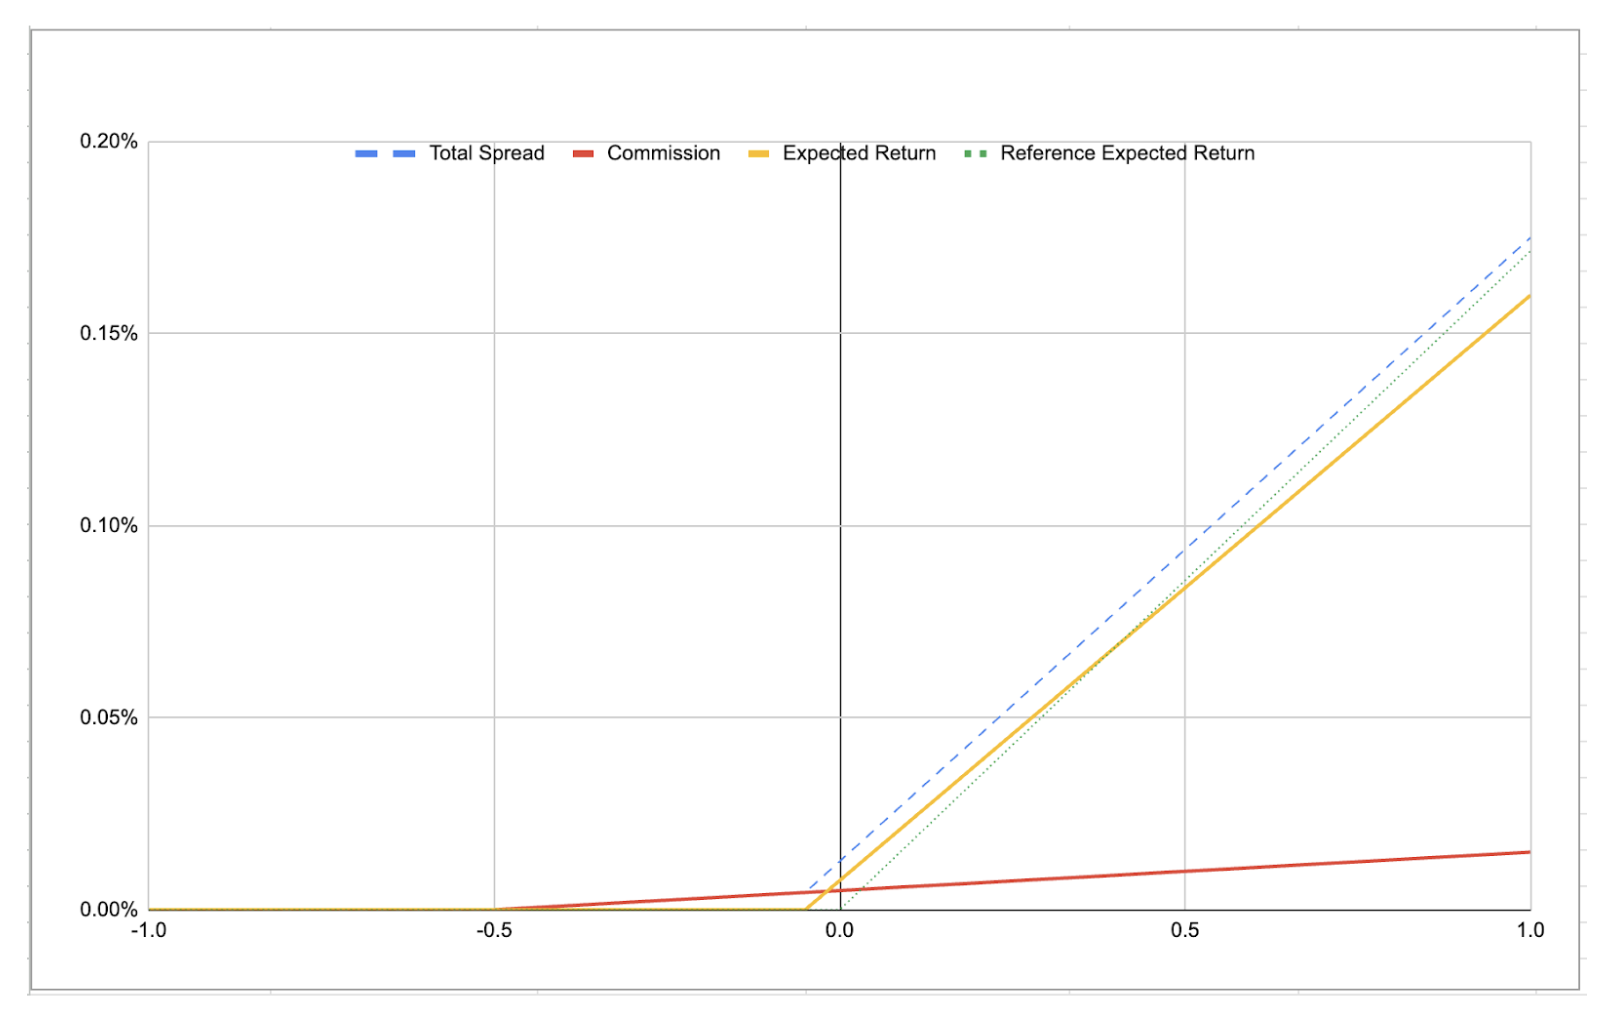

In [2]:
from IPython.display import Image
display(Image(filename="images/Sask.png", width=500))

More on the two components here: ([DSI BO Tool - explained](https://docs.google.com/document/d/1Xm5IP_ewjQCwKKLPqJTz7DuiI4xzI3v29m4OJPmhHj4/edit)). 

We break down the two components of the spread. Consider $S_{ask}$ and observe the first component:

$$
max(Perf\kappa_{ask} x + \epsilon_{ask}, 0)
$$

* This refers to the expected $PnL$ function from earlier.
  * We shift it horizontally with $\epsilon_{ask, Ref}$ to account for where (in terms of $diff$) we expect the clients to start winning;
  * We apply $\kappa \sim \mu dt T$ to account for the drift from the $PnL$ function;
  * We apply $\max(\cdot,0)$ to prevent negative spread.
  * The Dealing team can adjust  $Perf$ to account for when customers are under or over-performing.

More details on the idea behind $\kappa$ and $\epsilon$ in section 6.

Now, for the second part:

$$
\max \left((com_{max} - com_{min})x + com_{min}, 0 \right)
$$

* This refers to the commission and and additional charges for other risk factors, similar to other products. Here, the charge has some key points:
  * At $diff=1$, the extra charge is $com_{max}$, which accounts for any possible PnL variance / trade concentration risk.
  * At $diff=0$, the extra charge is $com_{min}$, which is used for when we think the current state is stationary, i.e a driftles GBM 
  * At $diff \leq \frac{-com_{min}}{com_{max} - com_{min}} < 0$, the commission charged is 0

$S_{bid}$ is similar, but flipped on the $y$-axis and $\kappa_{bid},\epsilon_{bid}$ differ from $\kappa_{ask},\epsilon_{ask}$.

The rest are detailed in [DSI BO Tool - explained](https://docs.google.com/document/d/1Xm5IP_ewjQCwKKLPqJTz7DuiI4xzI3v29m4OJPmhHj4/edit) and can be calculated in [DSI BO Tool](https://docs.google.com/document/d/13lLR7P7x-nPd4F37sjsl8GGSPBM4vm_RtD0XRXBnZqE/edit)

According to [DSI10/20/30 - BO specs](https://docs.google.com/document/d/13lLR7P7x-nPd4F37sjsl8GGSPBM4vm_RtD0XRXBnZqE/edit), some spread parameters can be set in BackOffice:
* $Perf$, $com_{max}$, $com_{min}$ will be set by the **Dealing** team regularly in BackOffice
* $\kappa$, $\epsilon$ will be hard-coded

Hence, there are some constraints:

1. $com_{max} > com_{min}$. By how much depends on the Dealing team;
2. $0 < Perf \leq 2$
3. $com_{max},com_{min} > 0$



### <u>Spread Specifications</u>

[DSI10/20/30 - BO Specs](https://docs.google.com/document/d/13lLR7P7x-nPd4F37sjsl8GGSPBM4vm_RtD0XRXBnZqE/edit) has an indicative example of the specs. The $\kappa$ & $\epsilon$ in the picture below are the current values implemented.

Currently, the commission specs for each DSI (Demo 14/09/2023 onwards) are as follows:

```
Demo_Phase_2: # Demo at 14/09/2023 onwards
  DSI10:
    perf: 0.45
    com_min: 36
    com_max: 72

  DSI20:
    perf: 0.37
    com_min: 31
    com_max: 62

  DSI30:
    perf: 0.3
    com_min: 24
    com_max: 48
```

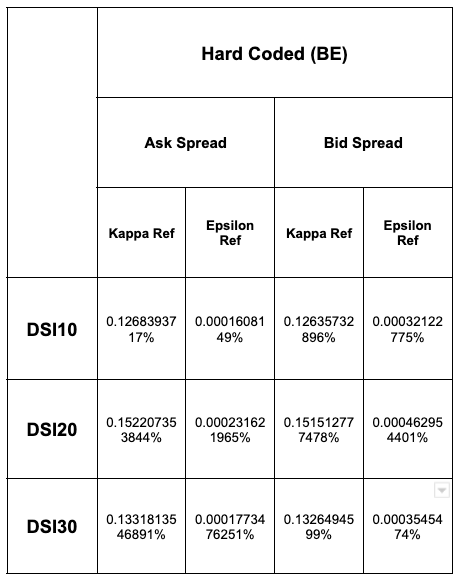

In [1]:
from IPython.display import Image
display(Image(filename='images/indicative_drift_spread.png', width=450))

### Spread -- Justification

Essentially, the spread above is similar to forward pricing on DSI as detailed in the documents of section 6. Pricing CFDs using the forward prices of the index is a valid method that isn't arbitrageable for the "perfect" strategy described above. Furthermore, this method of bid/ask generation can be generated quickly. 

### MT5

In MT5, customers will not see the spot, they will see the bid/ask prices (ask feed cannot be graphed by ticks):


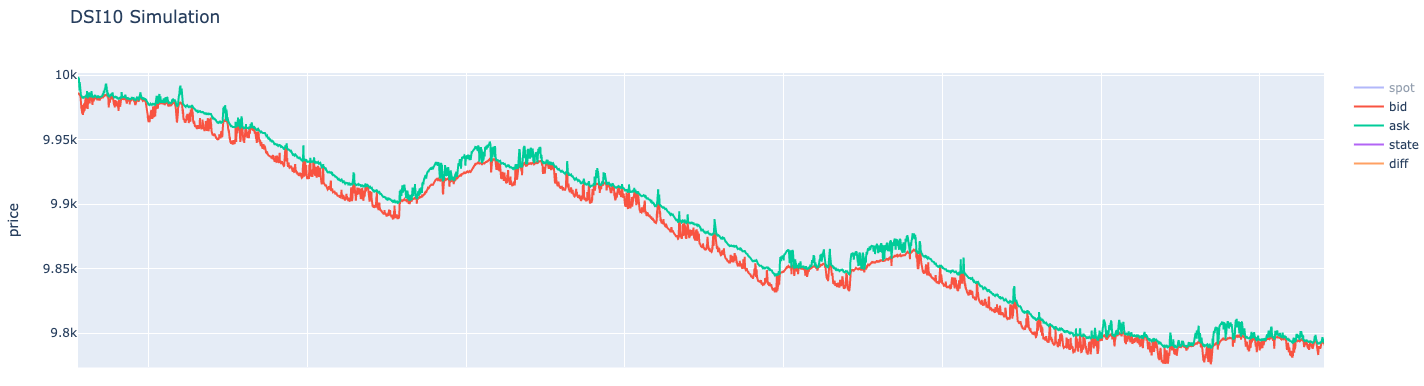

In [3]:
from IPython.display import Image
display(Image(filename='images/DSI10bidask.png', width=1200))

## Model Validation

### Summary

For the validation of DSI indices, we cover the below areas and conclude the outcomes. More details can be found in the respective sections.

|Section|Area|Validation|Outcome|Passed?|
|-|-|-|-|-|
|1|States/Xi storage in Feeddb|The actual states are currently stored in feeddb which poses a potential operational risk. The following dataframes were tested with a sample "perfect" strategy using the state feed on various delays: <li> Monte Carlo 1 month data (Latest spread parameters) <li> Monte Carlo 1 week data (Latest spread parameters) <li> DevServer Data <li> Demo Data |The sample strategy resulted in high median/mean pnl per trade and high hit/win rate until a reasonably large delay: <li> DSI10: Profitable up to 2 minutes+ <li> DSI20: Profitable up to 5 minutes+ <li> DSI30: Profitable up to 10 minutes+ <br> <br> **Update** (4 October 2023): The view on the state column in `drift_switch_states` will be hidden on Metabase |<b>Passed</b>|
|2|$\gamma$ derivation and computation| <li>  Validation of derivation of $\gamma$ <li> Check that the production constants are correct <li> Use Monte Carlo to check what happens when $\gamma$ is not the right value | <li> Derivation is correct <li> Perl uses the constants derived by the formulas <li>  Using any other values for $\gamma$ results in mismatched drift|<b>Passed</b>|
|3|Stationary distribution verification, computation & convergence|<li> The state distribution for the feeddb/simulations should match the stationary distribution in the long term.<li> The convergence should also be checked|<li> Simulation: Generating a 3 month's state process and checking the final distribution shows that the error with the stationary distribution is less than 0.01 <li> Demo/DevServer: Similar results with max error of 0.03 <li> Convergence: TV Error is less than 0.05 within a week|<b>Passed</b>|
|4|Long term moments & convergence| <li>Feed moment data computation and cross-checking with simulation moments <li> Convergence speed testing|<li> Feed volatilities match, kurtosis and skewness are sufficiently small, but different <li> Moments converge approximately within a week|<b>Passed</b>|
|5|Backward engineering the parameters.| <li> Parameters are backward engineered from the feed data moments; <li> MLE is attempted| <li> The result looks fine with the set initial condition and boundary condition; <li> The MLE algorithm can retrieve $\mu$, $\sigma$ and the initial state accurately for each of the DSI <li> $T$ and transition probabilities can be retrieved with varying degrees of success (In descending order of accuracy: DSI10, DSI20, DSI30)|<b>Passed</b>|
|6|Spread formula| <li> Validation of the proofs & logic behind the spread formula <li> Spread parameter replication <li> Demo Feed Bid/Ask replication| <li> The proofs presented in the document are verified and valid. <li> The numbers match up with other methods of derivation <li> Replicated perfectly (minus rounding errors)|<b>Passed</b>|
|7|Correlation| Correlations between one-tick/hourly log returns of DSI10,20,30 are checked. The following indices are used: <li> Dev Spot <li> Demo Spot <li> Demo Phase 1/2 Bid <li> Demo Phase 1/2 Ask| The log returns are minimally correlated| <b>Passed</b>|


### Concerns
The current Production implementation stores historical states in Feeddb (feed.drift_switch_state). As concluded in section 1, if this information is obtained, even under a delay, this is a major insider trading opportunity.

It exists in Feeddb as an artifact of how the feed is implemented (additionally, it is useful for validation purposes), but we strongly urge preventing the storage of the states/xi at launch..

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc
from DSI import DSI_Engine, DSI_Factory, _generate_alpha
from DSI import OFFERED, SPREAD_VERSIONS
from DSI import DSI_SPECS as SPECS
from DSI import SPREAD_SPECS
from DSI_strats import DSI_MC_multiple_times, run_twosided_perfect_multiple_delays
from utils import read_list_dfs_from_parquet, write_list_dfs_to_parquet, read_csv_feeddb

pd.set_option("display.precision", 8)

# Use the latest spread parameters

DEVSERVER = SPREAD_VERSIONS[0]
DEMO_PHASE1 = SPREAD_VERSIONS[1]
DEMO_PHASE2 = SPREAD_VERSIONS[2]

def calculate_gamma(mu, dt, lambda_val : float):
    xp = (lambda_val * np.exp(mu * dt))/(1 - np.exp(mu * dt)*(1-lambda_val)) - 1
    xm = (lambda_val * np.exp(-mu * dt))/(1 - np.exp(-mu * dt)*(1-lambda_val)) - 1
    return (-2 * xm - xp * (1 + xm))/(xp - xm)

dt = 1/(365*86400)

# Constants
prod_gammas_only = {'DSI10' : 0.4980997907, 
                    'DSI20' : 0.4977183219,
                    'DSI30' : 0.4980031156}

prod_gammas = {k : {'Production' : v} for k,v in prod_gammas_only.items()}

# Gammas calculated from formula
actual_gammas = {}
for DSI_choice in OFFERED:
    specs = SPECS[DSI_choice]
    mu = specs['mu']
    T = specs['T']
    actual_gammas[DSI_choice] = calculate_gamma(mu, dt, 1/T)

### Data

We import the following data:

* Demo:
  * Full: 02/09/2023 onwards;
  * Phase 1: 02/09/2023 - 13/09/2023; 
  * Phase 2: 14/09/2023 onwards
* DevServer: 18/08/2023 - 29/08/2023.

Each dataset starts at midnight UTC. Phase 1 & DevServer end at midnight UTC. The demo data follows the commission specs:

```
Demo_Phase_1: # After Demo launch 02/09/2023 until 13/09/2023
  DSI10:
    perf: 0.6
    com_min: 36
    com_max: 72

  DSI20:
    perf: 0.6
    com_min: 31
    com_max: 62

  DSI30:
    perf: 0.6
    com_min: 24
    com_max: 48

Demo_Phase_2: # Demo at 14/09/2023 onwards
  DSI10:
    perf: 0.45
    com_min: 36
    com_max: 72

  DSI20:
    perf: 0.37
    com_min: 31
    com_max: 62

  DSI30:
    perf: 0.3
    com_min: 24
    com_max: 48
```

The Dev data uses an older version of the spread.

In [6]:
def xi_string_to_list(string):
    return np.array([float(s) for s in string[1:-1].split(',')], dtype=np.float64)

def generate_DSI_dicts(path):
    DSIs = read_csv_feeddb(path, source='QAbox')
    DSIs['xi'] = DSIs['xi'].apply(xi_string_to_list)

    return {
        'DSI10' : DSIs[DSIs['underlying'] == 'DSI10'].reset_index(drop=True),
        'DSI20' : DSIs[DSIs['underlying'] == 'DSI20'].reset_index(drop=True),
        'DSI30' : DSIs[DSIs['underlying'] == 'DSI30'].reset_index(drop=True)
    }
# Read Demo phase 1 db
DSIs_demo_phase_1_dict = generate_DSI_dicts('./data/3ways/DSIs_with_states_DEMO_Phase1_2023_09_02-13.csv')
# Read Demo phase 2 db
DSIs_demo_phase_2_dict = generate_DSI_dicts('./data/3ways/DSIs_with_states_DEMO_Phase2_2023_09_14-18.csv')
# Read entire Demo db
DSIs_demo_full_dict = generate_DSI_dicts('./data/3ways/DSIs_with_states_DEMO_ALL_2023_09_02-18.csv')
# Read DevServer db
DSIs_dev_dict = generate_DSI_dicts('./data/3ways/DSIs_with_states_DEV_2023_08_18-28.csv')

# Default Production Parameters
DSI_GENS = dict(zip(OFFERED, list(map(lambda x : DSI_Factory.create_DSI(x, DEMO_PHASE1, True),
                                 OFFERED))))

### Section 1

The states $X_t$ and the forecast probabilities $\xi_{t \mid t-1}$ are currently stored in feeddb. Inspecting the feed, new points get updated approximately every 1.5-2 minutes, up until 30s before the time of update. Considering how accessible feeddb is (SQL via Metabase or QABox), storing the values poses an operational risk. 

To quantify it, we run a Monte Carlo process on the perfect long/short strategy detailed above. We then repeat it for various delay values (simulating $X_t$ feed retrieval delay) and observe the mean/median pnl per trade and the win/hit rates.

We test on:

* Monte Carlo 1 month data (Latest spread parameters)
* Monte Carlo 1 week data (Latest spread parameters)

We also test on feed data, namely:

* Demo - Phase 1
* Demo - Phase 2
* DevServer
##### Results

We see that both 1 week / 1 month datasets have negligible differences.

1. Win rates drop off significantly faster than the rest of the statistics, they are still profitable per trade, until the rest of the statistics also drop off
2. Each DSI drops off at about
   1. DSI10: 2 minutes
   2. DSI20: 5 minutes
   3. DSI30: 10 minutes
3. Comparing Demo to Dev data, we see that the Dev data is less susceptible to this risk than the Demo data as Demo perf (60%) is significantly lesser than the Dev perf (100%).

NOTE: Swap rates, lot sizes and transaction costs aren't considered (stop loss could be considered, but it is negligible in this scheme)

ALSO: Comparing Demo to Dev data, we see that the Dev data is less susceptible to this risk than the Demo data as Demo perf (60%) is significantly lesser than the Dev perf (100%).

Typically, this would not be an issue, but the states & xi values are stored in feeddb, resulting in possible insider trading. Considering that it is accessible via QAbox and Metabase (at a 2 minute delay), it is not very difficult to take advantage of.

Currently, it exists in Feeddb as an artifact of how the feed is implemented (additionally, it is useful for validation purposes), but we strongly urge the removal of the states/xi at launch.

##### **Update (4 October 2023)**

It has been agreed to restrict Metabase access of the `drift_switch_state` table. In particular, the state column will not be accessible via question or SQL in Metabase. This would reduce visibility of the state column significantly, preventing . Note that the xi column will still be visible as 
* It is required for Model Validation, $Perf$ calibration and for revenue metrics ([DSI Expected Revenue](https://docs.google.com/document/d/1wkFRbqdoFgggAHD6BWkyZndfNrjoNVGqWNlBFa-qU4g/edit))
* It doesn't pose any risk as the ask/bid spread is just a transformation of the xi values (In particular, `diff = xi[0] - xi[2]`)

This solution was chosen as the alternative: removing states from being stored outright had the side-effects of requiring a choice of states at a system restart. Regardles of the choice of states, the unpredictability of frequency of restarting was the main reason this alternative was rejected.

As the chosen solution does not require any changes in the backend code, all testing in this document is up-to-date.

In [ ]:
### Generate 500 1 week samples & 300 1 month samples

def generate_DSI_MC_file(DSI_choice, iterations, num_steps, duration):
    DSI = DSI_Engine(DSI_choice, DEMO_PHASE1, True)
    filename = f'{DSI_choice}_MC_{duration}_08092023.parquet'
    display(f'Generating {iterations} * {num_steps} = {iterations * num_steps} points for {filename}')

    DSIs = DSI.generate_multiple_DSI_with_info(iterations, num_steps)

    write_list_dfs_to_parquet(DSIs, f'./data/3ways/{filename}')

run = False 

if run:
    iterations = 300
    num_steps = 86400*30
    for DSI_choice in OFFERED:
        generate_DSI_MC_file(DSI_choice, iterations, num_steps, '1m')


In [15]:
pd.options.mode.chained_assignment = None

def DSIs_perfect_strat_stats(DSI_to_check, delays, suffix):
    DSIs = read_list_dfs_from_parquet(f'./data/3ways/{DSI_to_check}_MC_{suffix}_08092023.parquet')

    average_pnls_cts_time, median_pnls_cts_time, hit_rates_cts_time, win_rates_cts_time = DSI_MC_multiple_times(DSIs, delays)
   
    mean_averages = average_pnls_cts_time.mean(axis=0)
    median_averages = median_pnls_cts_time.mean(axis=0)
    hit_rates_averages = hit_rates_cts_time.mean(axis=0)
    win_rates_averages = win_rates_cts_time.mean(axis=0)

    return mean_averages, median_averages, hit_rates_averages, win_rates_averages

def plot_perfect_strats(DSI_to_check, delays, mean, median, hit_rates, win_rates, duration):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4))
    ax1.plot(delays, mean)
    ax1.plot(delays, median)
    ax1.axhline(0, linestyle = '--', color = 'red')
    ax1.legend(['mean', 'median'])
    ax1.set_ylabel('average pnl per trade')
    ax1.set_xlabel('delay (s)')

    ax2.plot(delays, hit_rates)
    ax2.plot(delays, win_rates)
    ax2.axhline(0.5, linestyle = '--', color = 'red')
    ax2.legend(['hit rate', 'win rate'])
    ax2.set_ylabel('x rate')
    ax2.set_xlabel('delay (s)')
    fig.suptitle(f'{DSI_to_check} MC - multiple delay strategy statistics ({duration} timeframe)')

start = 0
space = 10
end = start + space + 600
delays = list(range(start, end, space))


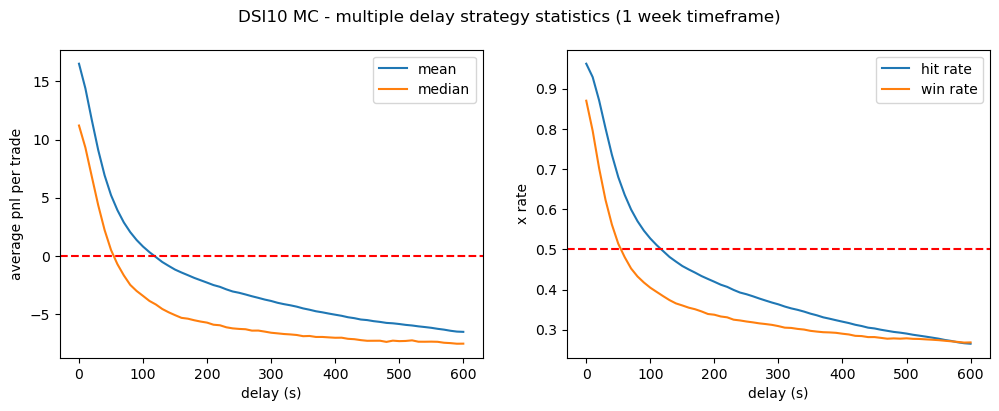

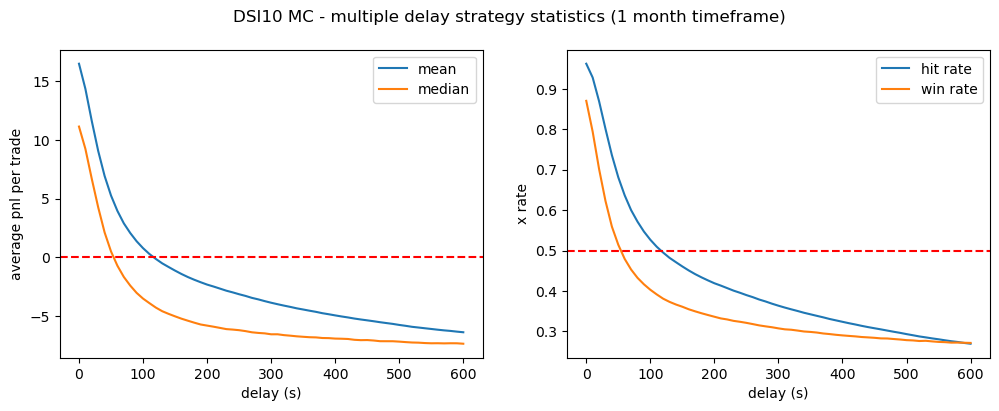

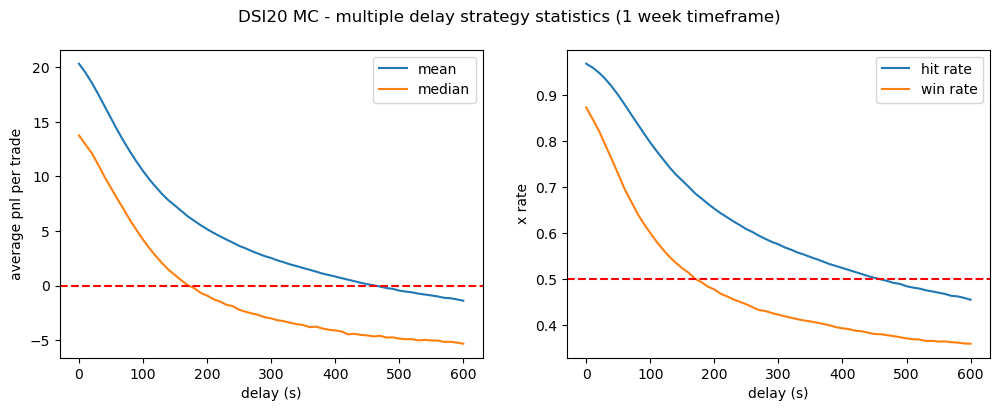

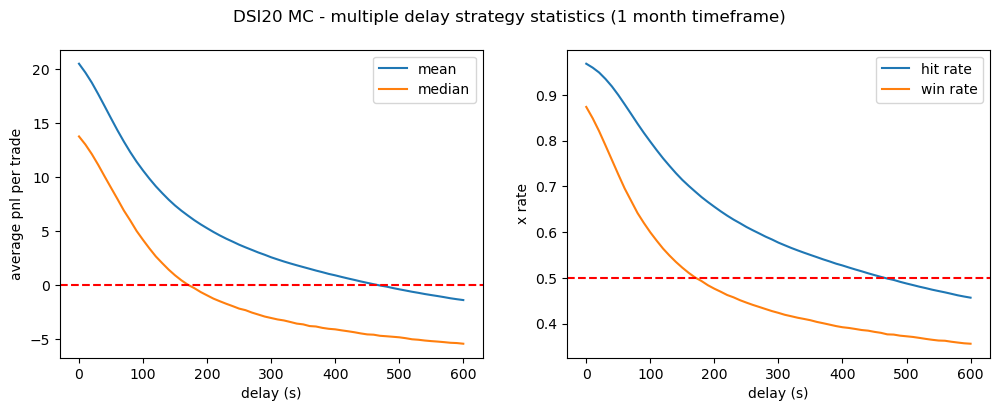

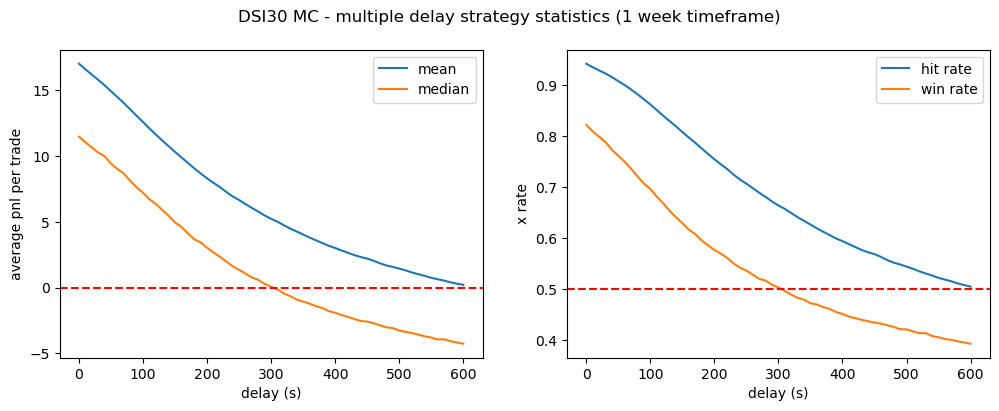

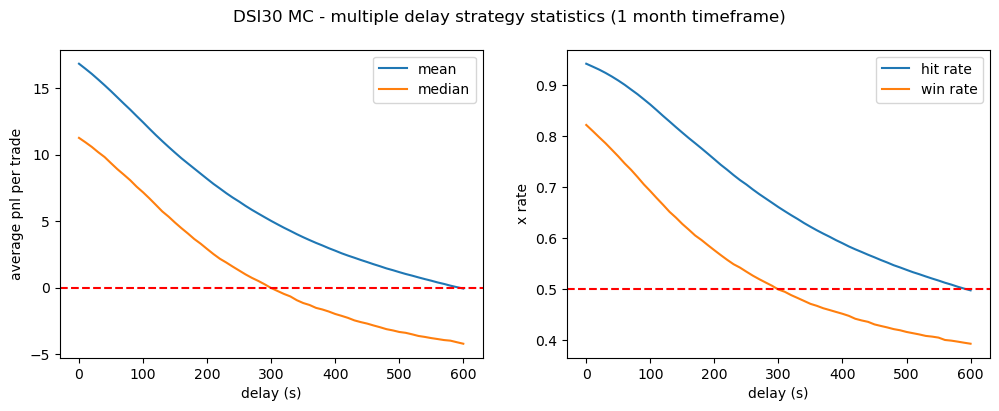

In [ ]:
for DSI_to_check in OFFERED:
    means_1w, medians_1w, hit_rates_1w, win_rates_1w = DSIs_perfect_strat_stats(DSI_to_check, delays, '1w')
    means_1m, medians_1m, hit_rates_1m, win_rates_1m = DSIs_perfect_strat_stats(DSI_to_check, delays, '1m')

    plot_perfect_strats(DSI_to_check, delays, means_1w, medians_1w, hit_rates_1w, win_rates_1w, '1 week')
    plot_perfect_strats(DSI_to_check, delays, means_1m, medians_1m, hit_rates_1m, win_rates_1m, '1 month')

Number of trades executed for DSI10 Demo Phase 1: 1073

Number of trades executed for DSI20 Demo Phase 1: 535

Number of trades executed for DSI30 Demo Phase 1: 340



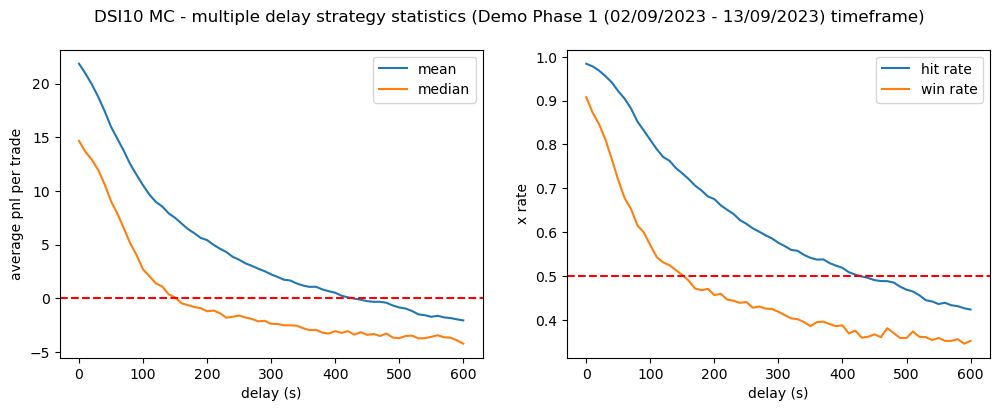

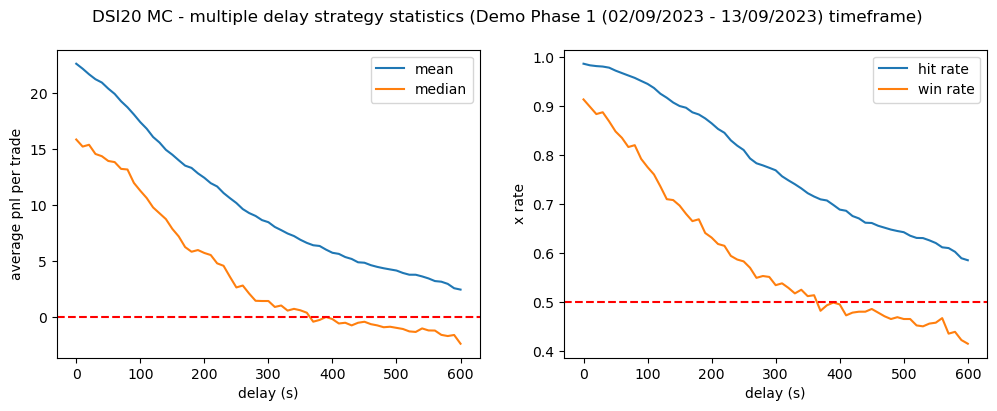

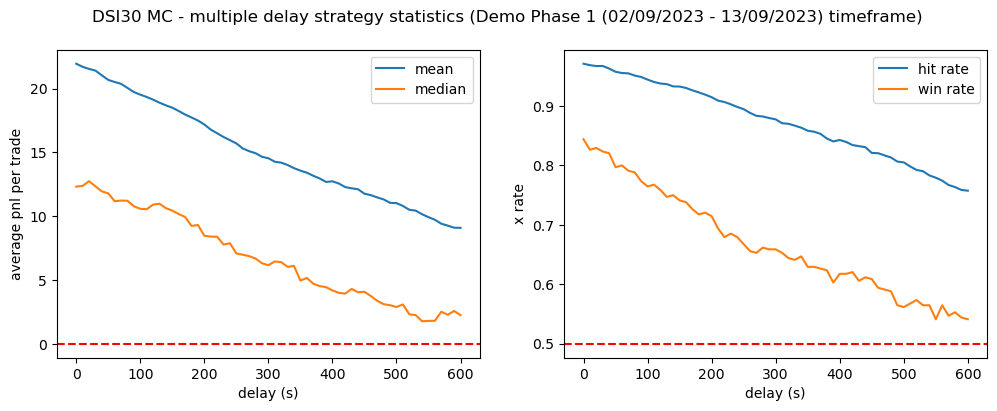

In [16]:
for DSI_to_check in OFFERED:
    DSI = DSIs_demo_phase_1_dict[DSI_to_check]
    trades, _, averages, medians, hit_rates, win_rates = run_twosided_perfect_multiple_delays(DSI, delays)
    print(f'Number of trades executed for {DSI_to_check} Demo Phase 1: {trades[0].num_trades.iloc[-1]}\n')
    plot_perfect_strats(DSI_to_check, delays, averages, medians, hit_rates, win_rates, 'Demo Phase 1 (02/09/2023 - 13/09/2023)')

Number of trades executed for DSI10 Demo Phase 2: 440

Number of trades executed for DSI20 Demo Phase 2: 205

Number of trades executed for DSI30 Demo Phase 2: 143



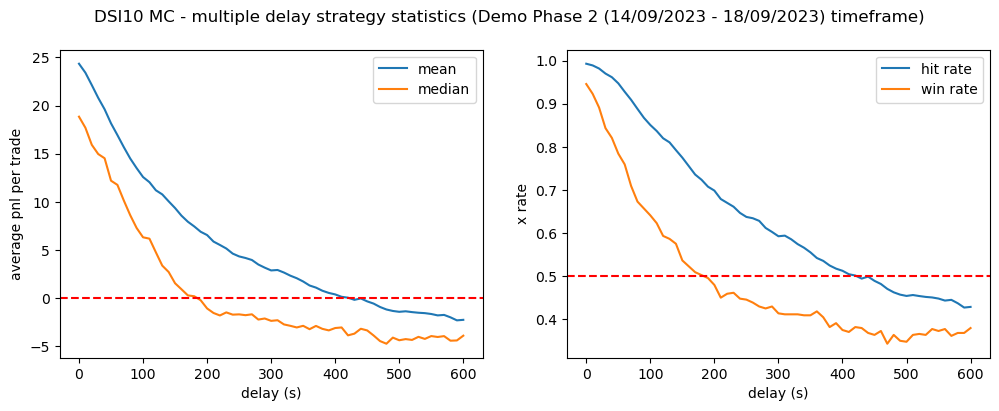

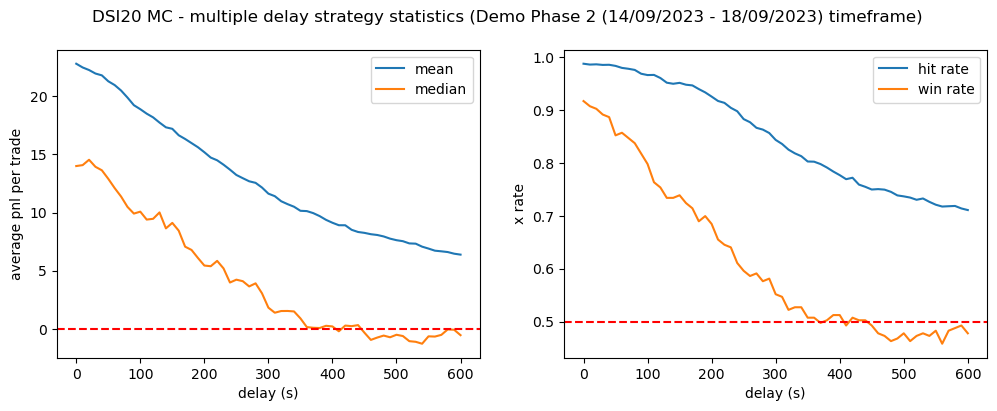

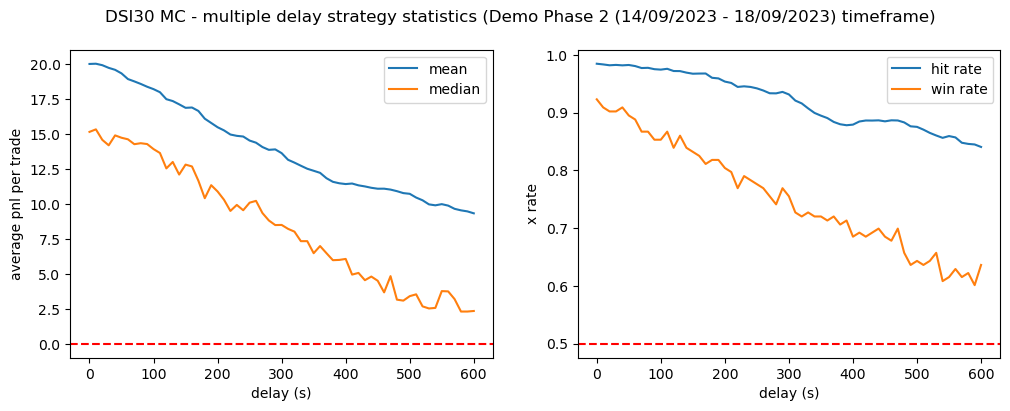

In [19]:
for DSI_to_check in OFFERED:
    DSI = DSIs_demo_phase_2_dict[DSI_to_check]
    trades, _, averages, medians, hit_rates, win_rates = run_twosided_perfect_multiple_delays(DSI, delays)
    print(f'Number of trades executed for {DSI_to_check} Demo Phase 2: {trades[0].num_trades.iloc[-1]}\n')
    plot_perfect_strats(DSI_to_check, delays, averages, medians, hit_rates, win_rates, 'Demo Phase 2 (14/09/2023 - 18/09/2023)')

Number of trades executed for DSI10 DevServer: 1082

Number of trades executed for DSI20 DevServer: 530

Number of trades executed for DSI30 DevServer: 356



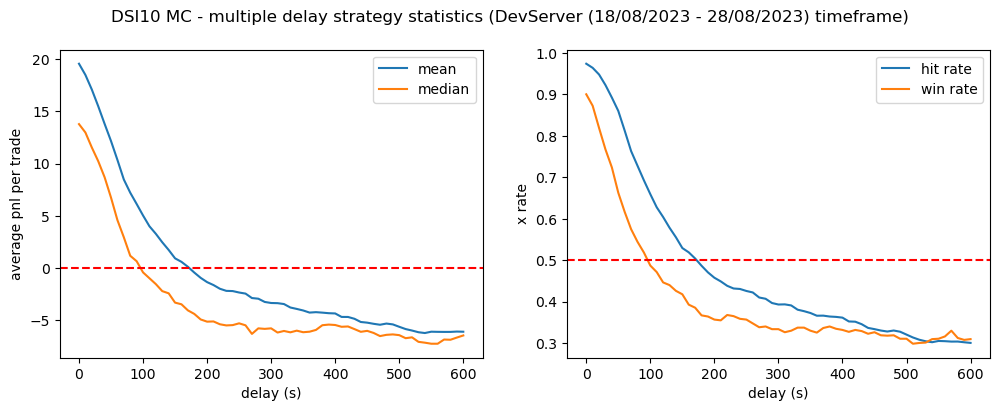

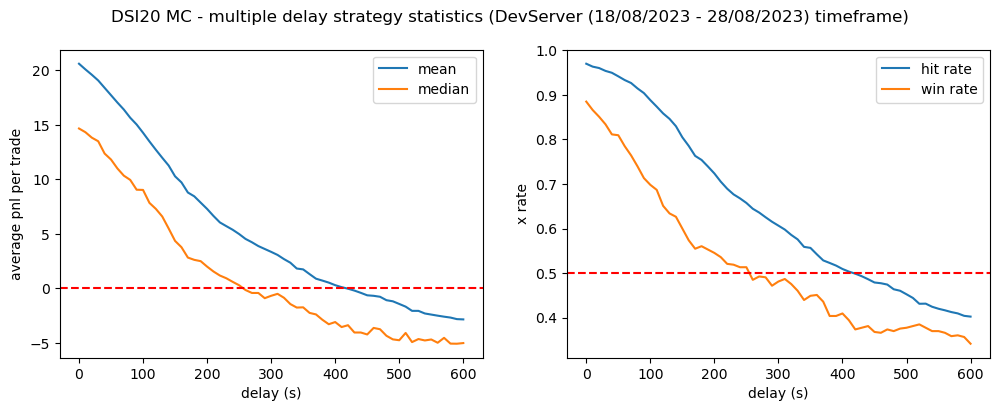

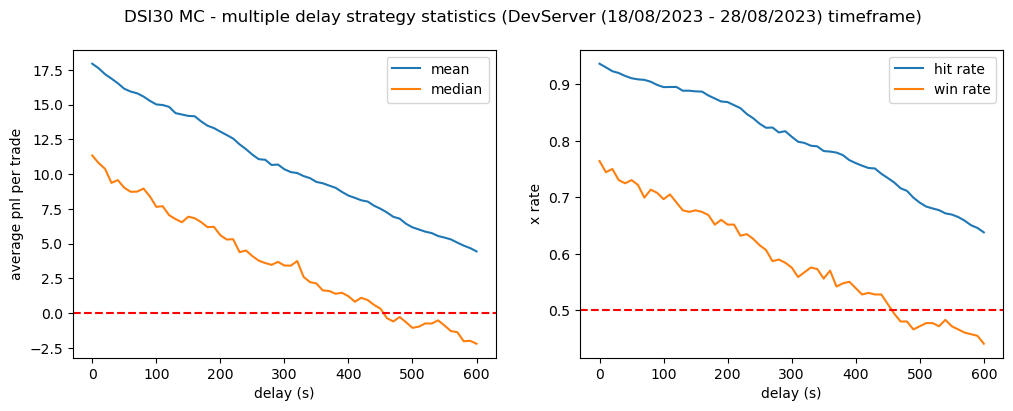

In [20]:
for DSI_to_check in OFFERED:
    DSI = DSIs_dev_dict[DSI_to_check]
    trades, _, averages, medians, hit_rates, win_rates = run_twosided_perfect_multiple_delays(DSI, delays)
    print(f'Number of trades executed for {DSI_to_check} DevServer: {trades[0].num_trades.iloc[-1]}\n')
    plot_perfect_strats(DSI_to_check, delays, averages, medians, hit_rates, win_rates, 'DevServer (18/08/2023 - 28/08/2023)')

### Section 2

Having the correct value for $\gamma$ is required to ensure that the DSI does not drift to infinity or 0. To verify the value:

1. The derivation/proof in the R&D document (p26-29) is validated
2. The production $\gamma$ numbers are checked with the formula provided
3. Monte Carlo simulations on the spot are performed for over/underestimated $\gamma$, then the mean for each case are compared

#### Derivation Validation

The derivation is indeed correct. However, the recurrence relations for $\gamma$ (R&D 9.3.8), critical to the proof were not explicitly proved in the document. The proof has been added to the appendix.


##### Result

With the help of Nolan on another similar proof, the recurrence relations are valid. Proof is contained in the appendix for completion's sake.

#### Directly checking $\gamma$ values

We compute $\gamma$ for each DSI; We need to calculate the following values first:

\begin{align*}
x_+ &= \frac{\lambda e^{\mu dt}}{1 - e^{\mu dt}(1-\lambda)} - 1 \\
x_- &= \frac{\lambda e^{-\mu dt}}{1 - e^{-\mu dt}(1-\lambda)} - 1 \\
\end{align*}

Then we can calculate $\gamma$:

\begin{equation*}
\gamma = \frac{-2x_- - x_+(1+x_+)}{x_+ - x_-}
\end{equation*}

And compare the calculated value to the production constant

##### Result

Production constants are within tolerance of the calculated gammas


In [ ]:
gamma_df = pd.DataFrame.from_dict(prod_gammas, orient='index')

for DSI_choice in OFFERED:
    DSI_specs = SPECS[DSI_choice]
    mu = DSI_specs['mu']
    T = DSI_specs['T']
    
    lambda_val = 1 / T
    dt = 1/(365*86400)

    gamma_df.loc[DSI_choice, 'Calculated'] = calculate_gamma(mu, dt, lambda_val)

gamma_df['Relative Error (%)'] = (gamma_df['Calculated'] - gamma_df['Production']) / gamma_df['Calculated'] * 100
display(gamma_df)



,Production,Calculated,Relative Error (%)
DSI10,0.49809979,0.49809979,8.97240454e-09
DSI20,0.49771832,0.49771832,1.70345038e-09
DSI30,0.49800312,0.49800312,-7.19538175e-09


#### Monte Carlo

Let $\gamma$ be value found in the specs. We perturb by various percentages to check whether setting $\gamma$ correctly is required. For each DSI and for each perturbation, we simulate 1000x 1 week data samples and check the mean log change from start to finish, i.e $\log(\frac{S_{T}}{S_{0}})$ where $T$ is the last tick generated.

The drifts are then compared to the expected drift, which requires knowledge of the stationary distribution:

$$
\mathbb{E}\left[\log\left( \frac{S_T}{S_{0}}\right)\right] = \left( \frac{2}{9} \mu (2 \gamma - 1) - \frac{\sigma^2}{2} \right) \cdot dt \cdot T
$$

##### Result
Gamma minimizes between the sample drifts and the expected drift, with some error as 1000 samples may be insufficient. However, generating any more iterations is difficult as this many points & iterations takes a toll on memory and a longer duration due to frequent garbage collections (to prevent memory leaks) and due to the sheer size of the datasets.

Mean Perturbations as % of production gamma                          \
                                            75.0%       90.0%       95.0%   
DSI10                                 -0.10958848 -0.04297083 -0.02192016   
DSI20                                 -0.06403644 -0.02708110 -0.01368692   
DSI30                                 -0.04038091 -0.01438821 -0.01000617   

                               
            97.5%       99.0%  
DSI10 -0.01529986 -0.00601624  
DSI20 -0.00471919 -0.00309488  
DSI30 -0.00561569 -0.00185244

Mean Perturbations as % of production gamma                          \
                                           100.0%      101.0%      102.5%   
DSI10                                  0.00204766  0.00281661  0.00776658   
DSI20                                 -0.00128039  0.00125661  0.00779704   
DSI30                                 -0.00277375  0.00133196  0.00328406   

                                           
           105.0%      110.0%      125.0%  
DSI10  0.01991803  0.04003903  0.10300554  
DSI20  0.01280392  0.02156387  0.06076686  
DSI30  0.00826042  0.01253908  0.03602312

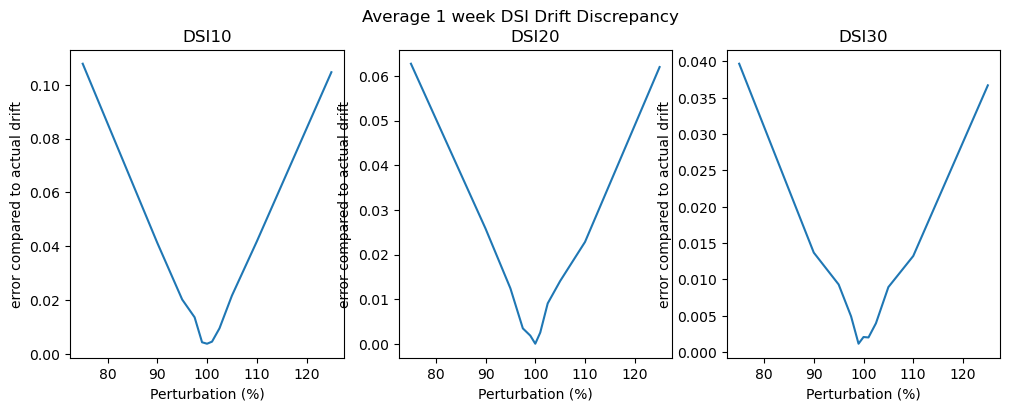

In [4]:
generate = False

expected_drifts = {}
iterations = 1000
num_steps = 86400 * 7
perturbations = np.sort(np.array([0.75, 0.9, 0.95, 0.975, 0.99, 1, 1.01, 1.025, 1.05, 1.1, 1.25]))
# Generate drifts by formula
for DSI_choice in OFFERED:
    specs = SPECS[DSI_choice]
    mu = specs['mu']
    sigma = specs['sigma']
    gamma = specs['gamma']

    # Calculated expected drift based on stationary distribution over 2 weeks
    expected_drifts[DSI_choice] = (2 / 9 * mu * (2 * gamma - 1) - sigma ** 2 / 2) * dt * num_steps

if generate:
    
    multi_index = tuple(zip(['Mean Perturbations as % of production gamma'] * perturbations.shape[0], map(lambda x : f'{(x * 100):.1f}%', perturbations)))

    columns = dict(zip(multi_index, [''] * len(perturbations)))
    df = pd.DataFrame(columns=columns, index=OFFERED)

    for DSI_choice in OFFERED:
        DSI = DSI_Engine(DSI_choice, DEMO_PHASE1)
        # Monte Carlo drifts
        for p in perturbations:
            perturbed_gamma = SPECS[DSI_choice]['gamma'] * p
            DSI.set_state(perturbed_gamma)
            DSI_generated = DSI.generate_multiple_DSI(iters = iterations, num_steps = num_steps)
            DSI_MC = np.array([DSI_generated[i][0] for i in range(iterations)])
            log_returns = np.log(DSI_MC[:,-1] / DSI_MC[:,0])
            df.loc[DSI_choice, ('Mean Perturbations as % of production gamma', f'{p * 100:.1f}%')] = log_returns.mean()
            
            # To prevent memory leaks -- Much slower but required
            del DSI_generated
            gc.collect()
            # print(f"Mean log deviation from centre for {DSI_choice}, {p = }, {perturbed_gamma = }: {log_returns.mean()}")
else:
    df = pd.read_csv('./data/3ways/1 week DSI drift stats.csv', header=[0,1], index_col=0)
# df.to_csv('1 week DSI drift stats.csv')

df1 = df.loc[:,(slice(None), list(map(lambda x : f'{(x * 100):.1f}%', perturbations[:len(perturbations) // 2])))]
df2 = df.loc[:,(slice(None), list(map(lambda x : f'{(x * 100):.1f}%', perturbations[len(perturbations) // 2:])))]
display(df1)
display(df2)


fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for DSI_choice, ax in zip(OFFERED, axes):
    ax.plot(df.columns.get_level_values(1).map(lambda x : float(x.strip('%'))), abs(df.loc[DSI_choice] - expected_drifts[DSI_choice]) )
    ax.set_title(DSI_choice)
    ax.set_ylabel('error compared to actual drift')
    ax.set_xlabel('Perturbation (%)')
fig.suptitle("Average 1 week DSI Drift Discrepancy");
        

### Section 3

Here, calculations on the transition matrix result in the stationary distribution (Refer to appendix):

$$
\pi = \begin{bmatrix}
\frac{2}{9}(1+\gamma) \\
\frac{1}{3} \\
\frac{2}{9}(2 - \gamma)
\end{bmatrix}
$$

We expect that:

* In the long term, $t \leq T$ for $T$ sufficiently large, the distribution of states $\{S_{t}\}_{t \leq T}$ should converge to the above distribution.

This should hold for the actual states.

#### Sanity check

We check that the above distribution is indeed stationary using production gamma.

##### Result

Applying the transition matrix to the above distribution resulted in the same one, hence it is indeed stationary

In [ ]:
for DSI_choice in OFFERED:
    DSI = DSI_Engine(DSI_choice, DEMO_PHASE1)
    state = DSI.state
    gamma = prod_gammas[DSI_choice]['Production']
    stationary = np.array([2/9 * (1+gamma), 1/3, 2/9 * (2 - gamma)])

    if np.isclose(computed := state @ stationary, stationary).all():
        print(f'{DSI_choice}: Derived stationary distribution is correct\n' 
              f'        stationary: {stationary},\n'
              f'state * stationary: {state @ stationary}\n')
    else:
        print(f'{DSI_choice}: Derived stationary distribution is incorrect:\n'
              f'        stationary: {stationary},\n'
              f'state * stationary: {state @ stationary}\n')

DSI10: Derived stationary distribution is correct
        stationary: [0.33291106 0.33333333 0.3337556 ],
state * stationary: [0.33291106 0.33333333 0.3337556 ]

DSI20: Derived stationary distribution is correct
        stationary: [0.33282629 0.33333333 0.33384037],
state * stationary: [0.33282629 0.33333333 0.33384037]

DSI30: Derived stationary distribution is correct
        stationary: [0.33288958 0.33333333 0.33377709],
state * stationary: [0.33288958 0.33333333 0.33377709]



#### Stationary Distribution Monte Carlo

Given state data, we take the empirical distribution of the generated states.

We consider the data:

* Simulated (3 months)
* Demo (2 weeks)
* DevServer (2.5 weeks)

We then consider the total variation (TV) errors of the empirical distribution $\nu$ and the stationary distribution $\pi$, that is:

$$
\|\nu - \pi\|_{TV} = \frac{1}{2} \sum_{x \in \{0,1,2\}} |\nu(x) - \pi(x)|
$$

We choose the TV error as it takes accounts of all possible events and chooses the worst case.

##### Results

* Sim: $\|\nu - \pi\|_{TV} < 0.01$
* Demo: $\|\nu - \pi\|_{TV} < 0.03$
* Dev: $\|\nu - \pi\|_{TV} < 0.03$

Note that this is an aggregate measure, and each component can be quite different, up to 5%

In [113]:
length = 86400 * 90
print('-'*80)
for DSI_choice in OFFERED:
    DSI_states = DSI_GENS[DSI_choice].generate_DSI_index_info(num_steps=length)['state']
    empirical_dist = np.array([(DSI_states == 0).sum(), (DSI_states == 1).sum(), (DSI_states == 2).sum()]) / DSI_states.shape[0]
    gamma = prod_gammas[DSI_choice]['Production']
    stationary = np.array([2/9 * (1+gamma), 1/3, 2/9 * (2 - gamma)])
    print(f'{DSI_choice} Sim: Comparison between sampled and actual stationary distributions\n' 
          f'            empirical: {empirical_dist},\n'
          f'           stationary: {stationary}\n'
          f'Total variation error: {np.linalg.norm(empirical_dist - stationary, 1) / 2}\n')
print('='*80)

--------------------------------------------------------------------------------
DSI10 Sim: Comparison between sampled and actual stationary distributions
            empirical: [0.33988473 0.33565942 0.32445585],
           stationary: [0.33291106 0.33333333 0.3337556 ]
Total variation error: 0.009299753874260325

DSI20 Sim: Comparison between sampled and actual stationary distributions
            empirical: [0.32508818 0.33406683 0.34084499],
           stationary: [0.33282629 0.33333333 0.33384037]
Total variation error: 0.007738115397553785

DSI30 Sim: Comparison between sampled and actual stationary distributions
            empirical: [0.34099031 0.32335747 0.33565222],
           stationary: [0.33288958 0.33333333 0.33377709]
Total variation error: 0.009975864629304138



In [108]:
length = 86400 * 90
print('-'*80)
for DSI_choice in OFFERED:
    DSI_states = DSIs_demo_full_dict[DSI_choice]['state']
    empirical_dist = np.array([(DSI_states == 0).sum(), (DSI_states == 1).sum(), (DSI_states == 2).sum()]) / DSI_states.shape[0]
    gamma = prod_gammas[DSI_choice]['Production']
    stationary = np.array([2/9 * (1+gamma), 1/3, 2/9 * (2 - gamma)])
    print(f'{DSI_choice} Demo: Comparison between sampled and actual stationary distributions\n' 
          f'            empirical: {empirical_dist},\n'
          f'           stationary: {stationary}\n'
          f'Total variation error: {np.linalg.norm(empirical_dist - stationary, 1) / 2}\n')
print('='*80)

--------------------------------------------------------------------------------
DSI10 Demo: Comparison between sampled and actual stationary distributions
            empirical: [0.350452   0.33337423 0.31617377],
           stationary: [0.33291106 0.33333333 0.3337556 ]
Total variation error: 0.017581833006066944

DSI20 Demo: Comparison between sampled and actual stationary distributions
            empirical: [0.33320428 0.32539281 0.34140291],
           stationary: [0.33282629 0.33333333 0.33384037]
Total variation error: 0.007940520844572418

DSI30 Demo: Comparison between sampled and actual stationary distributions
            empirical: [0.34598387 0.31057309 0.34344304],
           stationary: [0.33288958 0.33333333 0.33377709]
Total variation error: 0.022760240697919626



In [114]:
length = 86400 * 90
print('-'*80)
for DSI_choice in OFFERED:
    DSI_states = DSIs_dev_dict[DSI_choice]['state']
    empirical_dist = np.array([(DSI_states == 0).sum(), (DSI_states == 1).sum(), (DSI_states == 2).sum()]) / DSI_states.shape[0]
    gamma = prod_gammas[DSI_choice]['Production']
    stationary = np.array([2/9 * (1+gamma), 1/3, 2/9 * (2 - gamma)])
    print(f'{DSI_choice} DevServer: Comparison between sampled and actual stationary distributions\n' 
          f'            empirical: {empirical_dist},\n'
          f'           stationary: {stationary}\n'
          f'Total variation error: {np.linalg.norm(empirical_dist - stationary, 1) / 2}\n')
print('='*80)

--------------------------------------------------------------------------------
DSI10 DevServer: Comparison between sampled and actual stationary distributions
            empirical: [0.34610203 0.32896601 0.32493196],
           stationary: [0.33291106 0.33333333 0.3337556 ]
Total variation error: 0.013190968526982566

DSI20 DevServer: Comparison between sampled and actual stationary distributions
            empirical: [0.36081952 0.33185288 0.30732759],
           stationary: [0.33282629 0.33333333 0.33384037]
Total variation error: 0.027993229652031798

DSI30 DevServer: Comparison between sampled and actual stationary distributions
            empirical: [0.35483318 0.33763716 0.30752966],
           stationary: [0.33288958 0.33333333 0.33377709]
Total variation error: 0.026247422059553577



#### Convergence Testing

We check the convergence of the empirical distribution by calculating the empirical distribution at each step and checking the TV error. We test the same sets of data as before. We skip the first 100k data points or so, as the cumulative proportion can be very volatile at small sample sizes. 

##### Result
The TV errors tend to enter a 0.05 threshold within a week.

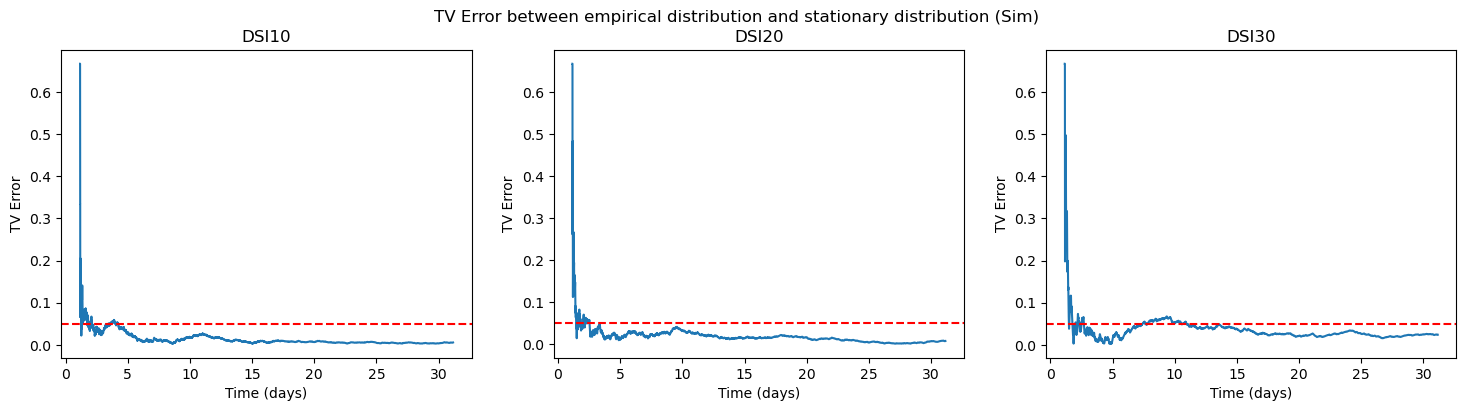

In [5]:
seed = 1235
rng = np.random.default_rng(seed)
num_steps = 86_400 * 30
start_at = 100_000
fig, axes = plt.subplots(1, 3, figsize = (18,4))
ax_dict = dict(zip(OFFERED, axes))

for DSI_choice in OFFERED:
    DSI = DSI_Engine(DSI_choice, DEMO_PHASE1, True)
    transition = DSI.state
    gamma = prod_gammas_only[DSI_choice]
    random_nums = rng.random(size=(num_steps))
    
    states = pd.Series(_generate_alpha(transition, random_nums))
    # Generate expanding cumulative distribution
    states_count_df = pd.DataFrame(columns=[0,1,2], index=range(states.shape[0]))
    for i in [0,1,2]:
        states_count_df.loc[0, i] = 0
        arr = states[states==i].groupby(states[states==i]).cumcount()+1
        states_count_df.loc[arr.index, i] = arr
    states_count_df.fillna(method='ffill', inplace=True)
    states_count_df = states_count_df.div(states_count_df.index + 1, axis=0)
    stationary = np.array([[2/9 * (1+gamma), 1/3, 2/9 * (2 - gamma)]])

    TVEs = np.linalg.norm(states_count_df - stationary, 1, axis=1) / 2
    ax_dict[DSI_choice].plot((np.array(range(len(TVEs)))+100000)/86400, TVEs)
    ax_dict[DSI_choice].axhline(0.05, color = 'red', ls = '--')
    ax_dict[DSI_choice].set_title(DSI_choice)
    ax_dict[DSI_choice].set_xlabel('Time (days)')
    ax_dict[DSI_choice].set_ylabel('TV Error')

fig.suptitle('TV Error between empirical distribution and stationary distribution (Sim)');

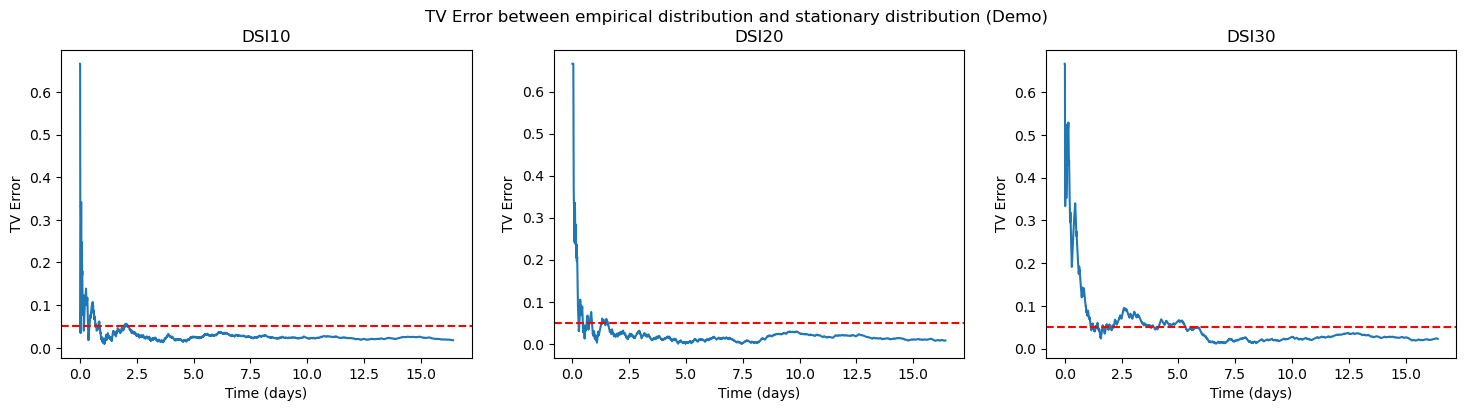

In [6]:
start_at = 100_000
fig, axes = plt.subplots(1, 3, figsize = (18, 4))
ax_dict = dict(zip(OFFERED, axes))

for DSI_choice in OFFERED:
    DSI = DSI_Engine(DSI_choice, DEMO_PHASE1, True)
    transition = DSI.state
    gamma = prod_gammas_only[DSI_choice]
    states = DSIs_demo_full_dict[DSI_choice]['state']
    # Generate expanding cumulative distribution
    states_count_df = pd.DataFrame(columns=[0,1,2], index=range(states.shape[0]))
    for i in [0,1,2]:
        states_count_df.loc[0, i] = 0
        arr = states[states==i].groupby(states[states==i]).cumcount()+1
        states_count_df.loc[arr.index, i] = arr
    states_count_df.fillna(method='ffill', inplace=True)
    states_count_df = states_count_df.div(states_count_df.index + 1, axis=0)
    stationary = np.array([[2/9 * (1+gamma), 1/3, 2/9 * (2 - gamma)]])

    TVEs = np.linalg.norm(states_count_df - stationary, 1, axis=1) / 2
    ax_dict[DSI_choice].plot(np.array(range(len(TVEs)))/86400, TVEs)
    ax_dict[DSI_choice].axhline(0.05, color = 'red', ls = '--')
    ax_dict[DSI_choice].set_title(DSI_choice)
    ax_dict[DSI_choice].set_xlabel('Time (days)')
    ax_dict[DSI_choice].set_ylabel('TV Error')

fig.suptitle('TV Error between empirical distribution and stationary distribution (Demo)');

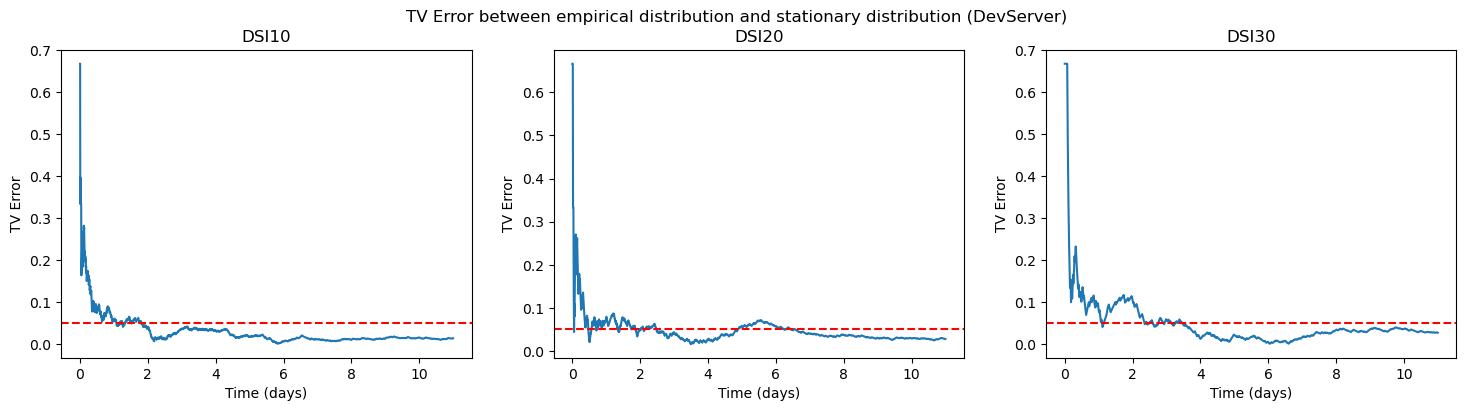

In [7]:
start_at = 100_000
fig, axes = plt.subplots(1, 3, figsize = (18, 4))
ax_dict = dict(zip(OFFERED, axes))

for DSI_choice in OFFERED:
    DSI = DSI_Engine(DSI_choice, DEMO_PHASE1, True)
    transition = DSI.state
    gamma = prod_gammas_only[DSI_choice]
    random_nums = rng.random(size=(num_steps))
    
    states = DSIs_dev_dict[DSI_choice]['state']
    # Generate expanding cumulative distribution
    states_count_df = pd.DataFrame(columns=[0,1,2], index=range(states.shape[0]))
    for i in [0,1,2]:
        states_count_df.loc[0, i] = 0
        arr = states[states==i].groupby(states[states==i]).cumcount()+1
        states_count_df.loc[arr.index, i] = arr
    states_count_df.fillna(method='ffill', inplace=True)
    states_count_df = states_count_df.div(states_count_df.index + 1, axis=0)
    stationary = np.array([[2/9 * (1+gamma), 1/3, 2/9 * (2 - gamma)]])

    TVEs = np.linalg.norm(states_count_df - stationary, 1, axis=1) / 2
    ax_dict[DSI_choice].plot(np.array(range(len(TVEs)))/86400, TVEs)
    ax_dict[DSI_choice].axhline(0.05, color = 'red', ls = '--')
    ax_dict[DSI_choice].set_title(DSI_choice)
    ax_dict[DSI_choice].set_xlabel('Time (days)')
    ax_dict[DSI_choice].set_ylabel('TV Error')

fig.suptitle('TV Error between empirical distribution and stationary distribution (DevServer)');

### Section 4

#### Moment cross-checking
We check the moments of real feed data and compare them to the simulation. In particular:

1. Obtain spot feed data from Metabase
2. Compute feed data moments of 1 tick log-returns (Mean, Volatility, Skewness, Kurtosis)
3. Run a 180 day simulation and compute their 1 tick log-return moments
4. Compare 2. and 3.

We expect to find a roughly centered normal-like distribution, i.e

* Skewness: 0
* (Excess) Kurtosis: 0

##### Results
We see that the Demo & Simulated data are close in volatility, but tend to differ in the other parameters.

In [29]:
# Then compute each of the moments using pandas functions
duration = 86400 * 180
return_duration = 1
columns1 = pd.MultiIndex.from_product([['Mean', 'Volatility'], ['Sim', 'Dev', 'Demo']], names=['Moments', 'Data'])
columns2 = pd.MultiIndex.from_product([['Skew', 'Kurtosis'], ['Sim', 'Dev', 'Demo']], names=['Moments', 'Data'])
df1 = pd.DataFrame(index=OFFERED, columns = columns1)
df2 = pd.DataFrame(index=OFFERED, columns = columns2)

for DSI_choice in OFFERED:
    # Calculate the simulated moments
    DSI = DSI_Engine(DSI_choice, DEMO_PHASE1, True)
    DSI_df = DSI.generate_DSI_index(duration, pandas=True)
    log_returns = np.log(DSI_df['spot'] / DSI_df['spot'].shift(return_duration)).dropna()
    df1.loc[DSI_choice,('Mean','Sim')] = log_returns.mean()
    df1.loc[DSI_choice,('Volatility','Sim')] = log_returns.std() / np.sqrt(dt * return_duration)
    df2.loc[DSI_choice,('Skew','Sim')] = log_returns.skew()
    df2.loc[DSI_choice,('Kurtosis','Sim')] = log_returns.kurtosis()

    # Calculate demo moments
    DSI_demo_df = DSIs_demo_full_dict[DSI_choice]
    log_returns = np.log(DSI_demo_df['spot'] / DSI_demo_df['spot'].shift(return_duration)).dropna()
    df1.loc[DSI_choice,('Mean','Demo')] = log_returns.mean()
    df1.loc[DSI_choice,('Volatility','Demo')] = log_returns.std() / np.sqrt(dt * return_duration)
    df2.loc[DSI_choice,('Skew','Demo')] = log_returns.skew()
    df2.loc[DSI_choice,('Kurtosis','Demo')] = log_returns.kurtosis()

    # Calculate dev moments
    DSI_dev_df = DSIs_dev_dict[DSI_choice]
    log_returns = np.log(DSI_dev_df['spot'] / DSI_dev_df['spot'].shift(return_duration)).dropna()
    df1.loc[DSI_choice,('Mean','Dev')] = log_returns.mean()
    df1.loc[DSI_choice,('Volatility','Dev')] = log_returns.std() / np.sqrt(dt * return_duration)
    df2.loc[DSI_choice,('Skew','Dev')] = log_returns.skew()
    df2.loc[DSI_choice,('Kurtosis','Dev')] = log_returns.kurtosis()
display(df1)
display(df2)

errors1 = df1.copy()
errors2 = df2.copy()
for first in errors1.columns.get_level_values(0).drop_duplicates():
    errors1.loc[:,(first,'Demo')] = (errors1[first]['Sim'] - errors1[first]['Demo']) / errors1[first]['Sim'] * 100
    errors1.loc[:,(first,'Dev')] = (errors1[first]['Sim'] - errors1[first]['Dev']) / errors1[first]['Sim'] * 100
errors1 = errors1.drop('Sim', level=1, axis=1)
errors1.columns = errors1.columns.rename('Error with Sim (%)', level=0)

for first in errors2.columns.get_level_values(0).drop_duplicates():
    errors2.loc[:,(first,'Demo')] = (errors2[first]['Sim'] - errors2[first]['Demo']) / errors2[first]['Sim'] * 100
    errors2.loc[:,(first,'Dev')] = (errors2[first]['Sim'] - errors2[first]['Dev']) / errors2[first]['Sim'] * 100
errors2 = errors2.drop('Sim', level=1, axis=1)
errors2.columns = errors2.columns.rename('Error with Sim (%)', level=0)

display(errors1)
display(errors2)

Moments        Mean                          Volatility              \
Data            Sim         Dev        Demo         Sim         Dev   
DSI10   -0.00000002  0.00000003  0.00000014   0.1010398  0.10111771   
DSI20    0.00000003   0.0000001 -0.00000003  0.10039703  0.10032422   
DSI30   -0.00000001  0.00000009 -0.00000001   0.1001293  0.10017733   

Moments              
Data           Demo  
DSI10    0.10104511  
DSI20    0.10039828  
DSI30    0.10009356

Moments        Skew                            Kurtosis              \
Data            Sim         Dev        Demo         Sim         Dev   
DSI10   -0.00067277 -0.00389256 -0.00372993 -0.00183724 -0.00248631   
DSI20     0.0000533  0.00043905     0.00111 -0.00074716 -0.00612898   
DSI30   -0.00067841  0.00368372  0.00250332  0.00031672  0.00378606   

Moments              
Data           Demo  
DSI10    0.00143173  
DSI20    0.00192054  
DSI30    0.00346608

Error with Sim (%)           Mean                Volatility            
Data                          Dev          Demo         Dev        Demo
DSI10                228.04836215  696.10416673 -0.07710557  -0.0052574
DSI20               -275.55978188  205.08406846  0.07251995 -0.00124027
DSI30               1512.00158045    0.36792988 -0.04796731  0.03569853

Error with Sim (%)          Skew                     Kurtosis              
Data                         Dev          Demo            Dev          Demo
DSI10              -478.58353651 -454.41061516   -35.32836057  177.92797236
DSI20              -723.70286035 -1982.4967726  -720.30789543  357.04669462
DSI30               642.99348216  468.99891949 -1095.40134948 -994.37305703

### Convergence
We use expanding moments to observe the convergence

##### Results
We see that each moment converges approximately within a week

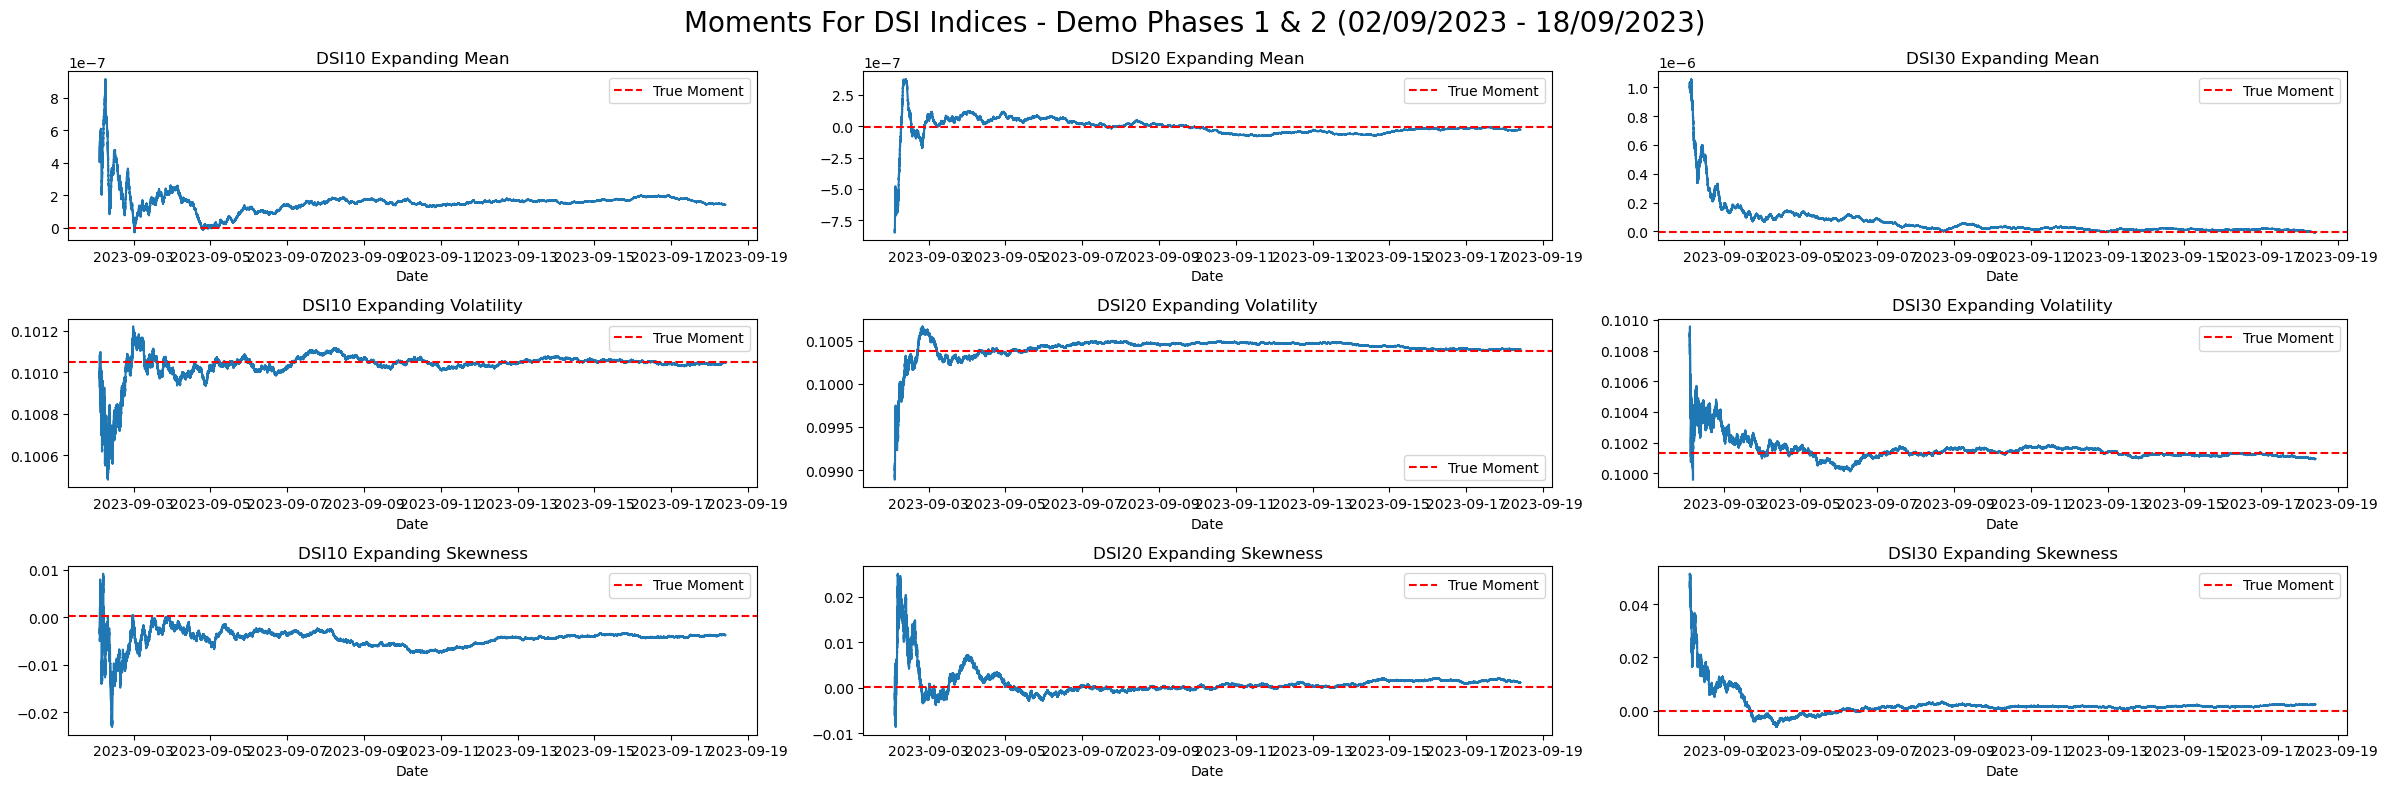

In [20]:
def DSI_moment_raw(mu, sigma, gamma, n):
    dt = 1 / (365 * 86400)

    # First, second & third moments of mu(Xt)
    stationary_one = 2 / 9 * mu * (2 * gamma - 1)
    stationary_two = 2 / 3 * mu ** 2
    stationary_three = 2 / 9 * mu ** 3 * (2 * gamma - 1)

    if n == 1:
        return (stationary_one - sigma ** 2 / 2) * dt
    elif n == 2:
        squared = stationary_two - stationary_one * sigma ** 2 + sigma ** 4 / 4
        return squared * dt ** 2 + sigma ** 2 * dt
    elif n == 3:
        squared = sigma ** 2 * stationary_one - 3 * sigma ** 4 / 2
        cubed = stationary_three - sigma ** 2 * stationary_two / 2 + sigma ** 4 * stationary_one - sigma ** 6 / 8
        return cubed * dt ** 3 + squared * dt ** 2
    else:
        raise NotImplementedError("DSI moments only implemented up to third moment")

def DSI_moment_standard(mu, sigma, gamma, n):
    raw_1 = DSI_moment_raw(mu, sigma, gamma, 1)
    if n == 1:
        return raw_1
    raw_2 = DSI_moment_raw(mu, sigma, gamma, 2)
    if n == 2:
        return raw_2 - raw_1**2
    raw_3 = DSI_moment_raw(mu, sigma, gamma, 3)
    if n == 3:
        return (raw_3 - 3 * raw_1 * raw_2 + 2 * raw_1 ** 3) / ((raw_2 - raw_1**2)**(3/2))
    else:
        raise NotImplementedError("DSI moments only implemented up to third moment")
    
# Plot expanding moments


fig, ax = plt.subplots(nrows=3,ncols=3,figsize=(24,8))
return_duration = 1
start_from = 10_000
for i, DSI_choice in enumerate(OFFERED):
    df = DSIs_demo_full_dict[DSI_choice]
    log_returns = np.log(df['spot'] / df['spot'].shift(return_duration))
    ax[0,i].plot(df['ts'][start_from:],log_returns.expanding().mean()[start_from:])
    ax[1,i].plot(df['ts'][start_from:],log_returns.expanding().std()[start_from:] / np.sqrt(dt * return_duration))
    ax[2,i].plot(df['ts'][start_from:],log_returns.expanding().skew()[start_from:])


    ax[0,i].set_title(f'{DSI_choice} Expanding Mean')
    ax[1,i].set_title(f'{DSI_choice} Expanding Volatility')
    ax[2,i].set_title(f'{DSI_choice} Expanding Skewness')

    DSI_specs = SPECS[DSI_choice]
    mu = DSI_specs['mu']
    sigma = DSI_specs['sigma']
    gamma = DSI_specs['gamma']
    mean = DSI_moment_standard(mu, sigma, gamma,1)
    std = np.sqrt(DSI_moment_standard(mu, sigma, gamma,2)) / np.sqrt(dt * return_duration)
    skew = DSI_moment_standard(mu, sigma, gamma,3)

    ax[0,i].axhline(mean,color='red',label='True Moment',linestyle='dashed')
    ax[1,i].axhline(std,color='red',label='True Moment',linestyle='dashed')
    ax[2,i].axhline(skew,color='red',label='True Moment',linestyle='dashed')

    for j in range(3):
        ax[j,i].set_xlabel('Date')
        ax[j,i].legend()

plt.suptitle("Moments For DSI Indices - Demo Phases 1 & 2 (02/09/2023 - 18/09/2023)", fontsize=20)
plt.tight_layout()

### Section 5

#### 
We backwards engineer the parameters $\mu$, $\sigma$ and $\gamma$ from the feed moments. Note that $T$ is not in the closed-form expression of the DSI moments, so it can't be checked via this method (formulas in appendix).

We use the full Demo data for testing.

##### Results
Results highly depend on the initial and boundary conditions, but are close to the actual values

In [18]:
from scipy.optimize import minimize

def obj_func(params, moments, n):
    eq =[DSI_moment_standard(mu=params[0], sigma=params[1], gamma=params[2], n=1) - moments[0], 
         DSI_moment_standard(mu=params[0], sigma=params[1], gamma=params[2], n=2) - moments[1], 
         DSI_moment_standard(mu=params[0], sigma=params[1], gamma=params[2], n=3) - moments[2]]

    # Use L^n norm, preferably 1 or 2
    result = np.linalg.norm(eq,n)
    return result

def emp_moment(log_returns, n):
    moment_1 = np.mean(log_returns)
    if n == 1: 
        return moment_1
    moment_2 = np.mean((log_returns - moment_1)**2)
    if n == 2: 
        return moment_2
    return np.mean((log_returns - moment_1)**n) / (moment_2**(n/2))

def params_solve(index,log_returns, n, tol):
    # Get the target
    moment_1 = emp_moment(log_returns, 1)
    moment_2 = emp_moment(log_returns, 2)
    moment_3 = emp_moment(log_returns, 3)

    moments = [moment_1,moment_2,moment_3]

    # Solve for the unknown parameters - mu, sigma, gamma
    if index == 'DSI10':
        params_guess = [100, 0.1, 0.4980997907]

    elif index == 'DSI20':
        params_guess = [60, 0.1, 0.4977183219]

    elif index == 'DSI30':
        params_guess = [35, 0.1, 0.4980031156]

    eps = 0.98
    params_guess = np.multiply(params_guess,eps)

    bound = 6*(1-eps)
    bounds = []
    for params in params_guess:
        bounds.append((params*(1-bound),params*(1+bound)))

    result = minimize(obj_func,params_guess,bounds=bounds,args=(moments, n), tol=tol)
    params_solve = result.x
    obj_val = result.fun
    return params_solve, obj_val

columns = pd.MultiIndex.from_product([['Mu', 'Sigma', 'Gamma'], ['Calculated', 'Actual']], names=['Parameters', 'Values'])
params = pd.DataFrame(index=OFFERED, columns = columns)

for DSI_choice in OFFERED:
    df = DSIs_demo_full_dict[DSI_choice]
    specs = SPECS[DSI_choice]
    log_returns = np.log(df['spot'] / df['spot'].shift(1)).dropna()
    (computed_mu, computed_sigma, computed_gamma), obj_val = params_solve(DSI_choice, log_returns, 1, tol=1e-10)
    params.loc[DSI_choice, ('Mu', 'Calculated')] = computed_mu
    params.loc[DSI_choice, ('Mu', 'Actual')] = specs["mu"]
    params.loc[DSI_choice, ('Sigma', 'Calculated')] = computed_sigma
    params.loc[DSI_choice, ('Sigma', 'Actual')] = specs["sigma"]
    params.loc[DSI_choice, ('Gamma', 'Calculated')] = computed_gamma
    params.loc[DSI_choice, ('Gamma', 'Actual')] = specs["gamma"]


display(params)

Parameters           Mu              Sigma              Gamma            
Values       Calculated Actual  Calculated Actual  Calculated      Actual
DSI10       97.99998129    100     0.10976    0.1  0.52672653  0.49809979
DSI20       58.79999984     60  0.09809322    0.1  0.48823608  0.49771832
DSI30       34.30001209     35  0.09408435    0.1  0.45652895  0.49800312

#### MLE

We also try the MLE algorithm for the Demo data. The MLE algorithm attempts to infer $\mu$, $\sigma$, $T$, the initial state $\xi_0$ and the transition probabilities. We run 50 iterations

Note that the transition probability graphs represent the exit distribution assuming the current state is $x$. For example, the following picture is an example of the case of $0$.


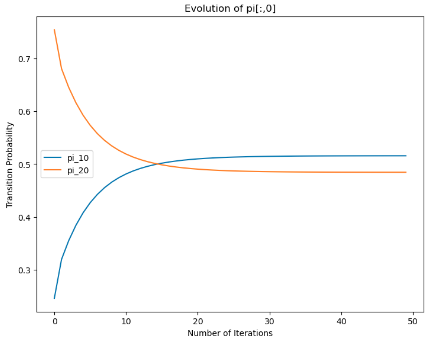

In [20]:
display(Image(filename='images/transition_eg.png'))

In this case, this implies that we've recovered the probabilities:

$$
\begin{bmatrix} \mathbb{P}[X_t = 1 \mid X_{t-1} = 0] \\ \mathbb{P}[X_t = 2 \mid X_{t-1} = 0] \end{bmatrix} = \begin{bmatrix} \pi_{10} \\ \pi_{20} \end{bmatrix} \approx \begin{bmatrix} 0.51 \\ 0.49 \end{bmatrix}
$$

Recalling that the first column of $P$, i.e the probability distribution of $X_{t}$ given $X_{t-1}$ has distribution $\left[1 - \lambda, \lambda / 2, \lambda / 2 \right]^T$, this implies that the actual exit distribution given $X_t = 0$ is $[0.5, 0.5]^T$.
##### Results
* We see that $\mu$, $\sigma$ and $\xi_0$ roughly converge to what we expect for all the DSIs. 
* $T$ roughly converges well for DSI10, gets somewhat close for DSI20, and does not converge very well for DSI30. This is likely because there are not enough data points to do so for DSI20 & DSI30 , as DSI20/DSI30 only has 72/48 jumps per day on average and we have only 4 weeks of demo data points at the time of writing
* The transition probabilities for DSI10 are the best approximated, while DSI20 & DSI30 don't converge to the correct values with the current information

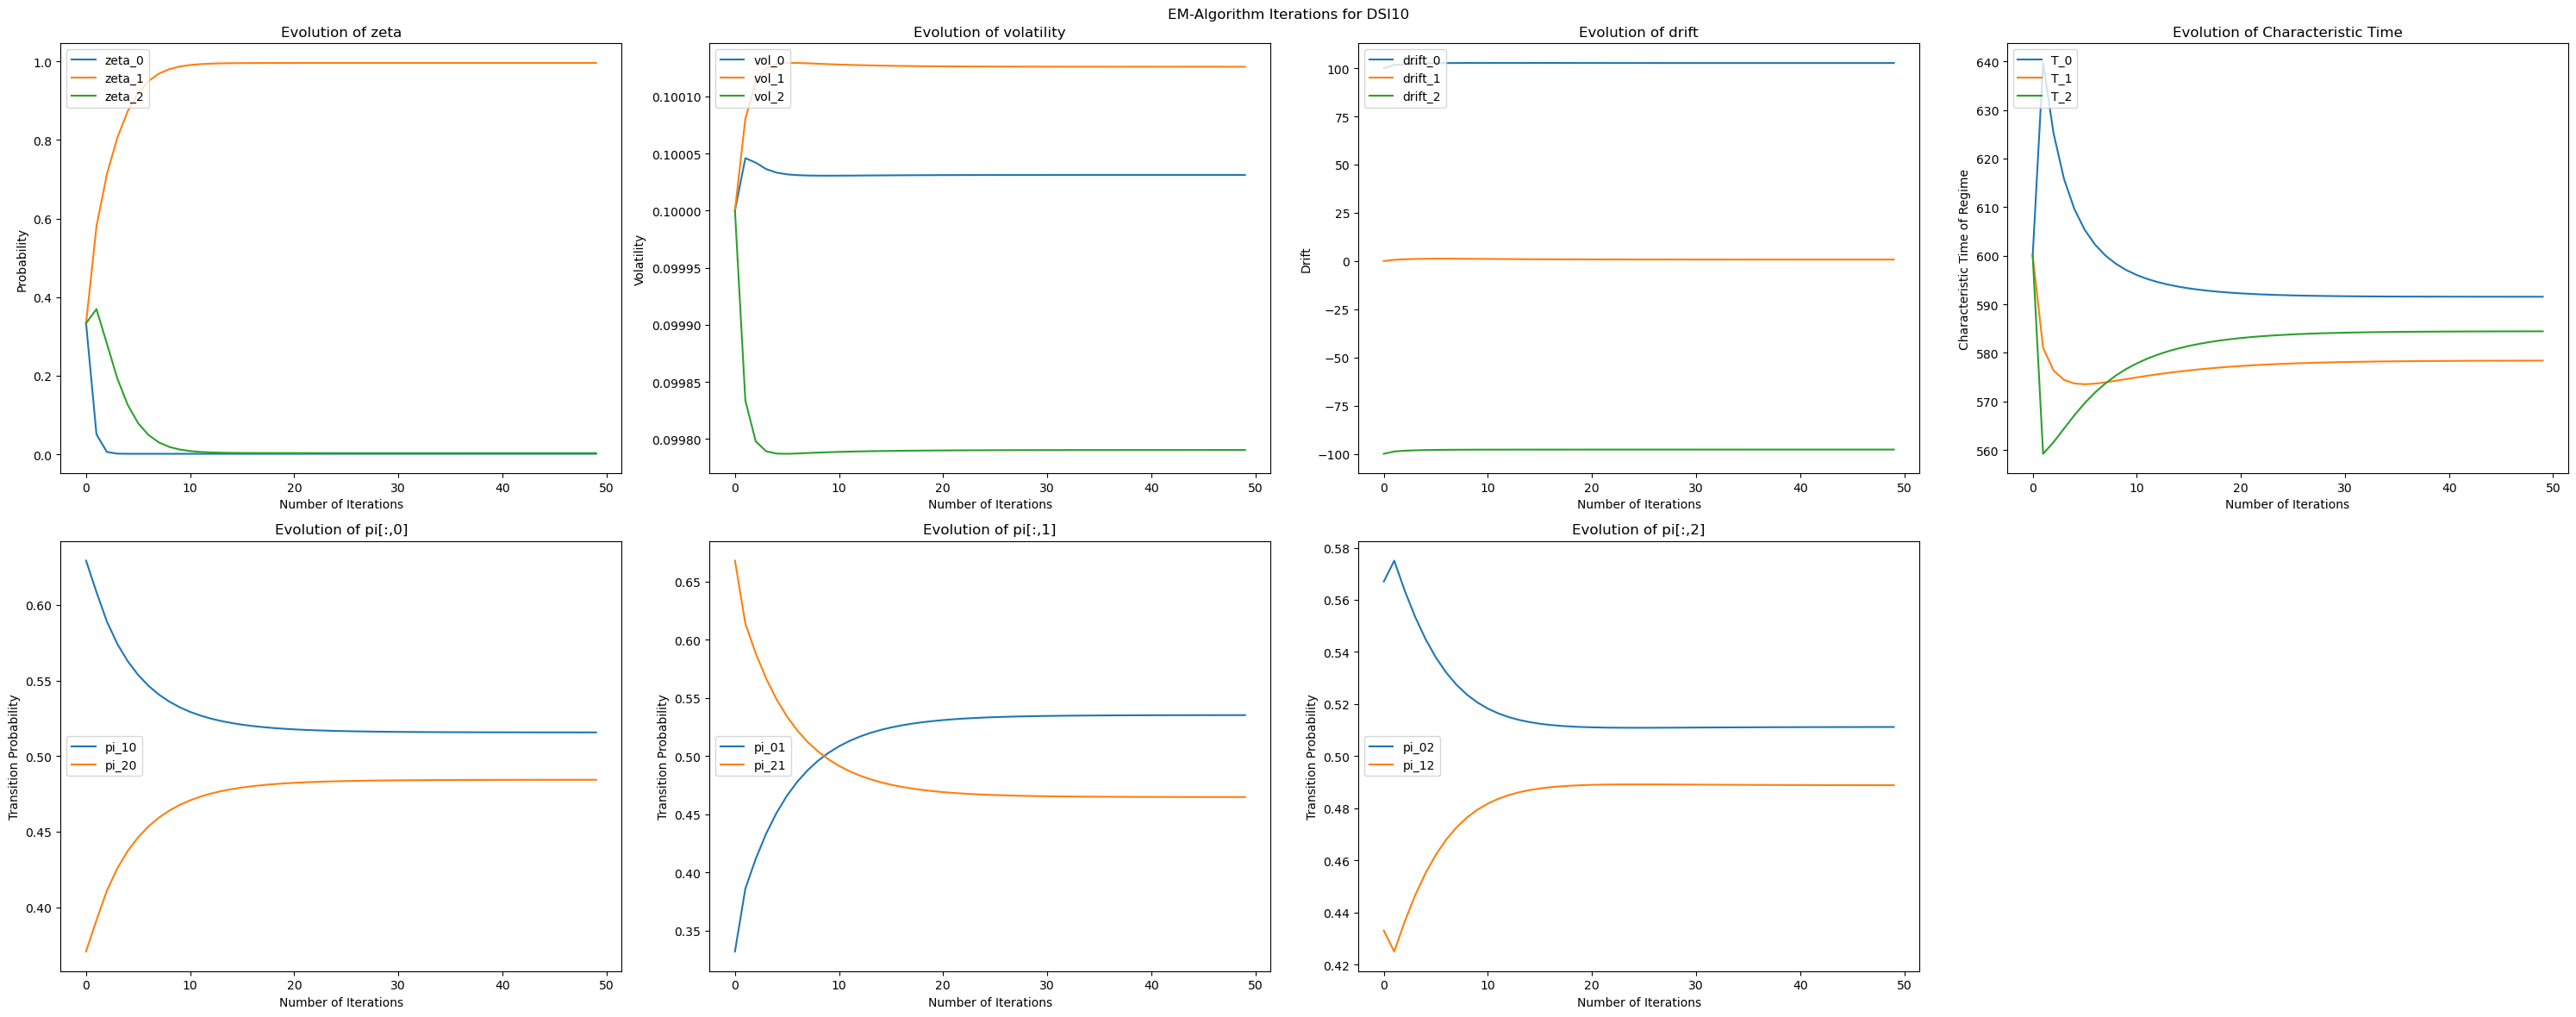

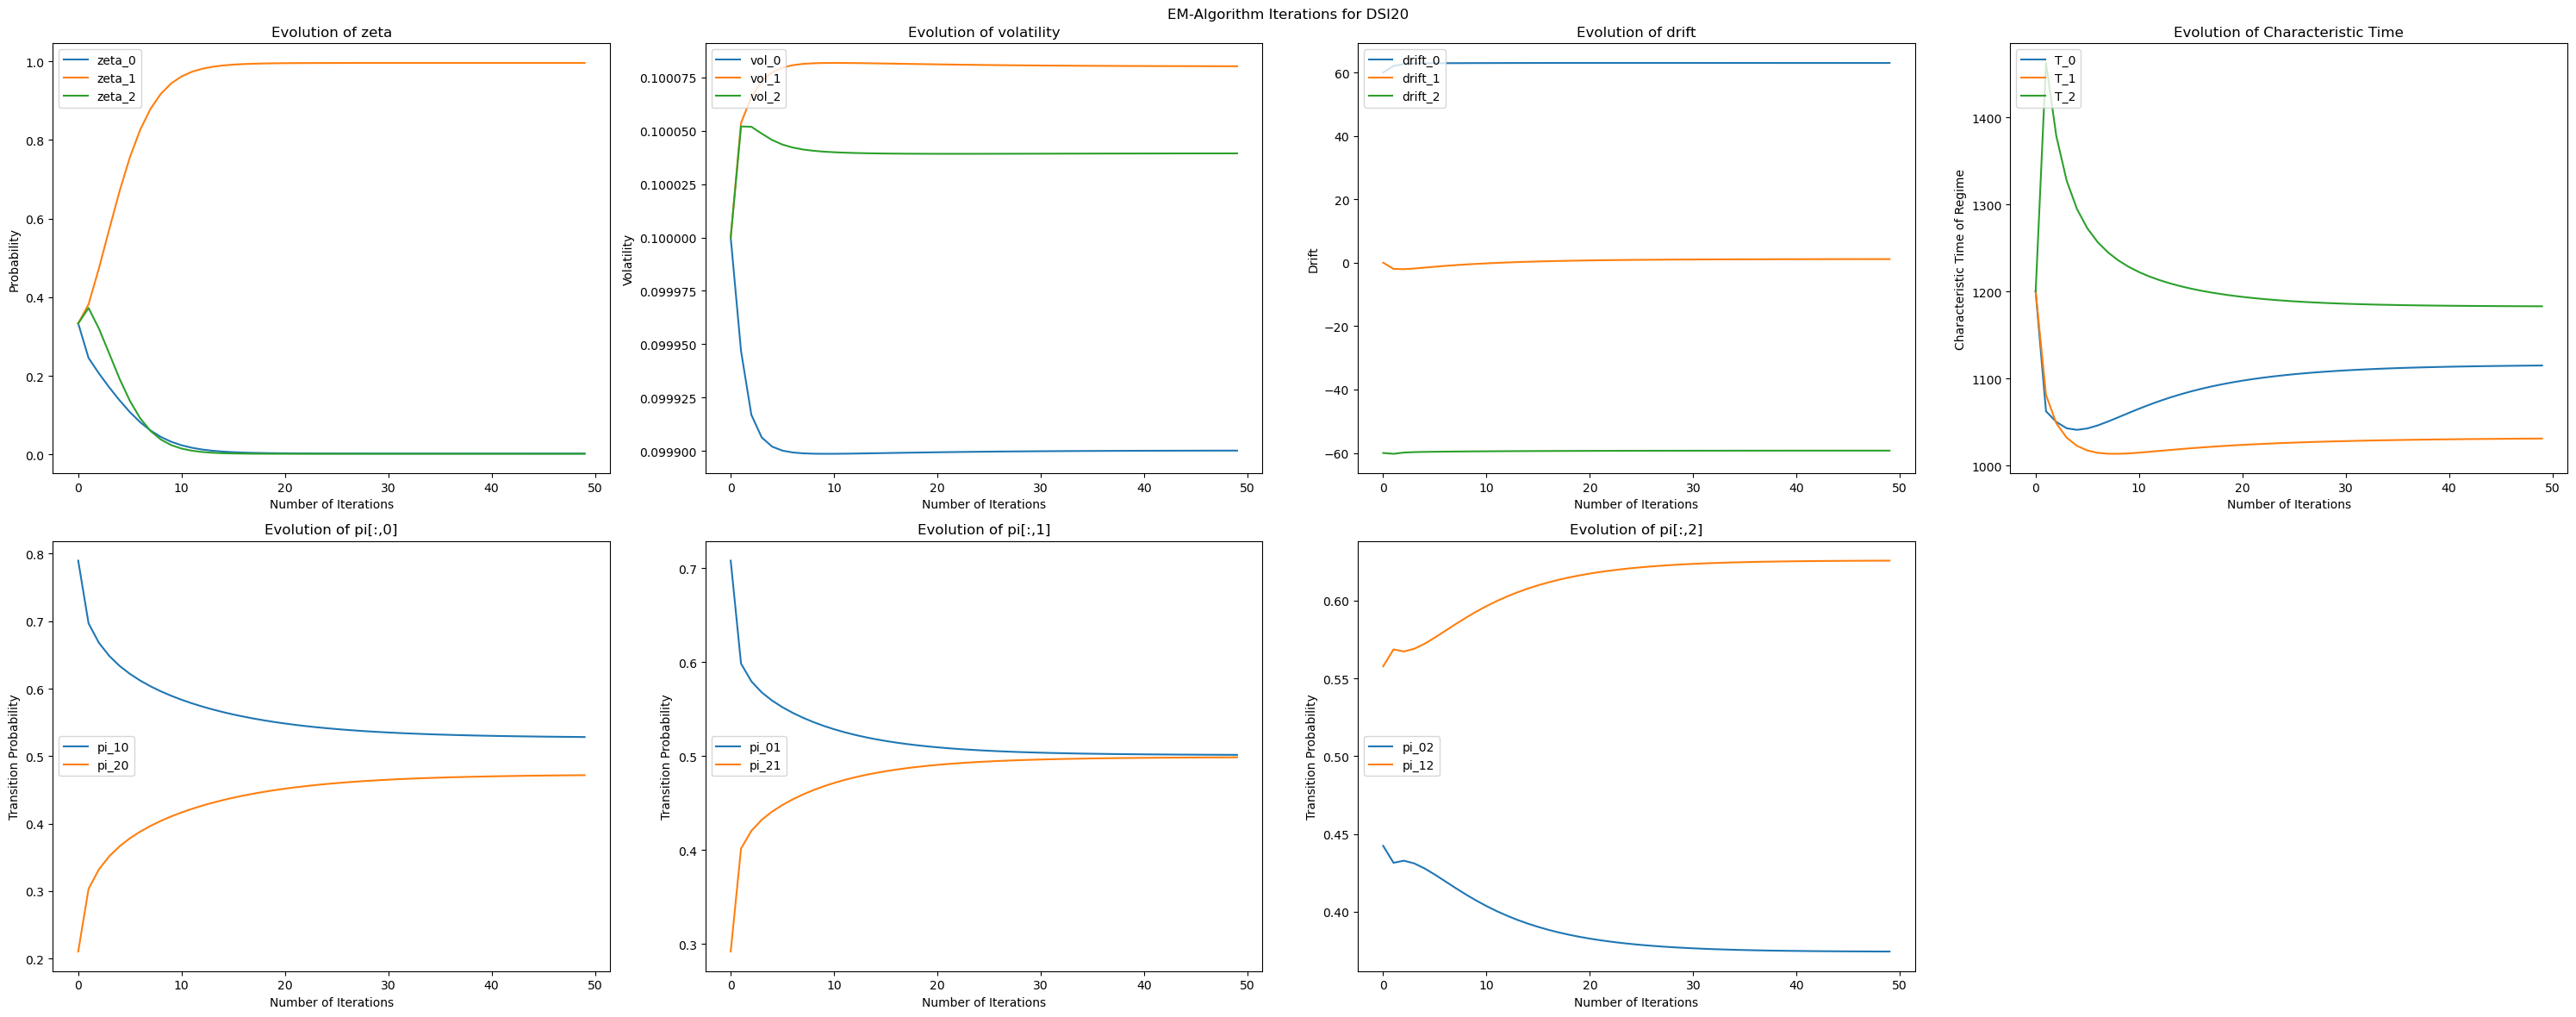

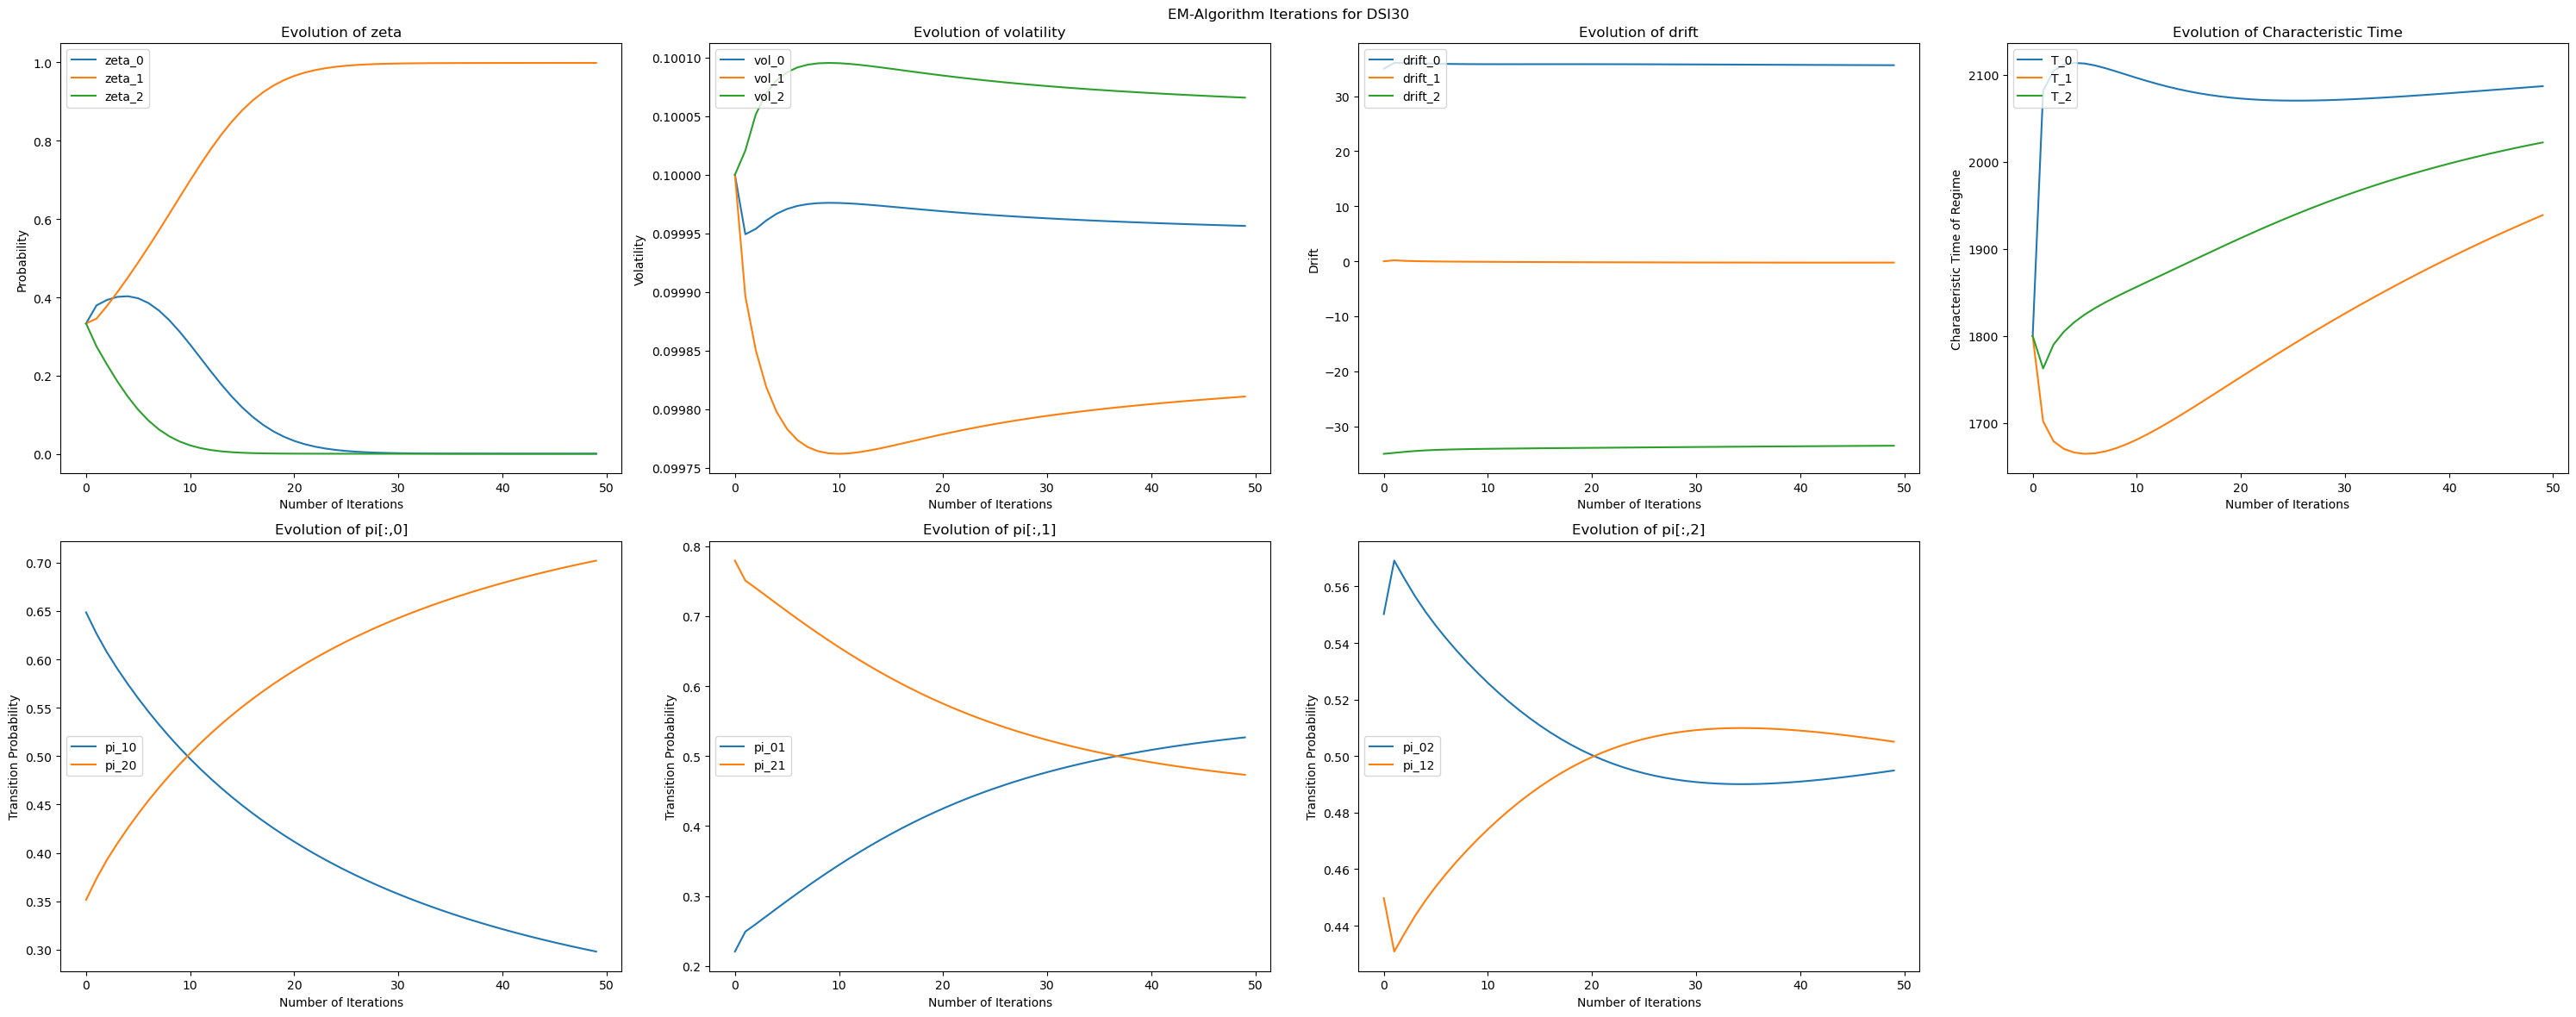

In [39]:
from EM_algo import EM_algo_general, see_convergence, init_P0
dt = 1/(365*86400)
MLE_results = {'DSI10' : {},
               'DSI20' : {},
               'DSI30' : {}}
for DSI_choice in OFFERED:
    specs = SPECS[DSI_choice]
    feed = DSIs_demo_full_dict[DSI_choice]
    log_returns = np.log(feed.spot/feed.spot.shift(1))

    T0 = np.ones(3)* specs['T']
    P0 = init_P0(T0)
    mu0 = np.array([1,0,-1])*dt * specs['mu']
    sigma0 = np.array([1,1,1])*np.sqrt(dt) * specs['sigma']
    zeta0 = np.ones(3) / 3
    NIt = 50
    P_EM, mu_EM, sigma_EM, zeta_EM, alpha_EM, beta_EM, chi_EM, phi_EM = EM_algo_general(log_returns[0:86400 * 30].dropna().to_numpy(),NIt,P0,mu0,sigma0,zeta0)
    MLE_results[DSI_choice]['P'] = P_EM[:,:,-1]
    MLE_results[DSI_choice]['mu'] = mu_EM[:,-1]
    MLE_results[DSI_choice]['sigma'] = sigma_EM[:,-1]
    MLE_results[DSI_choice]['zeta'] = zeta_EM[:,-1]
    see_convergence(P_EM, mu_EM, sigma_EM, zeta_EM, DSI_choice)

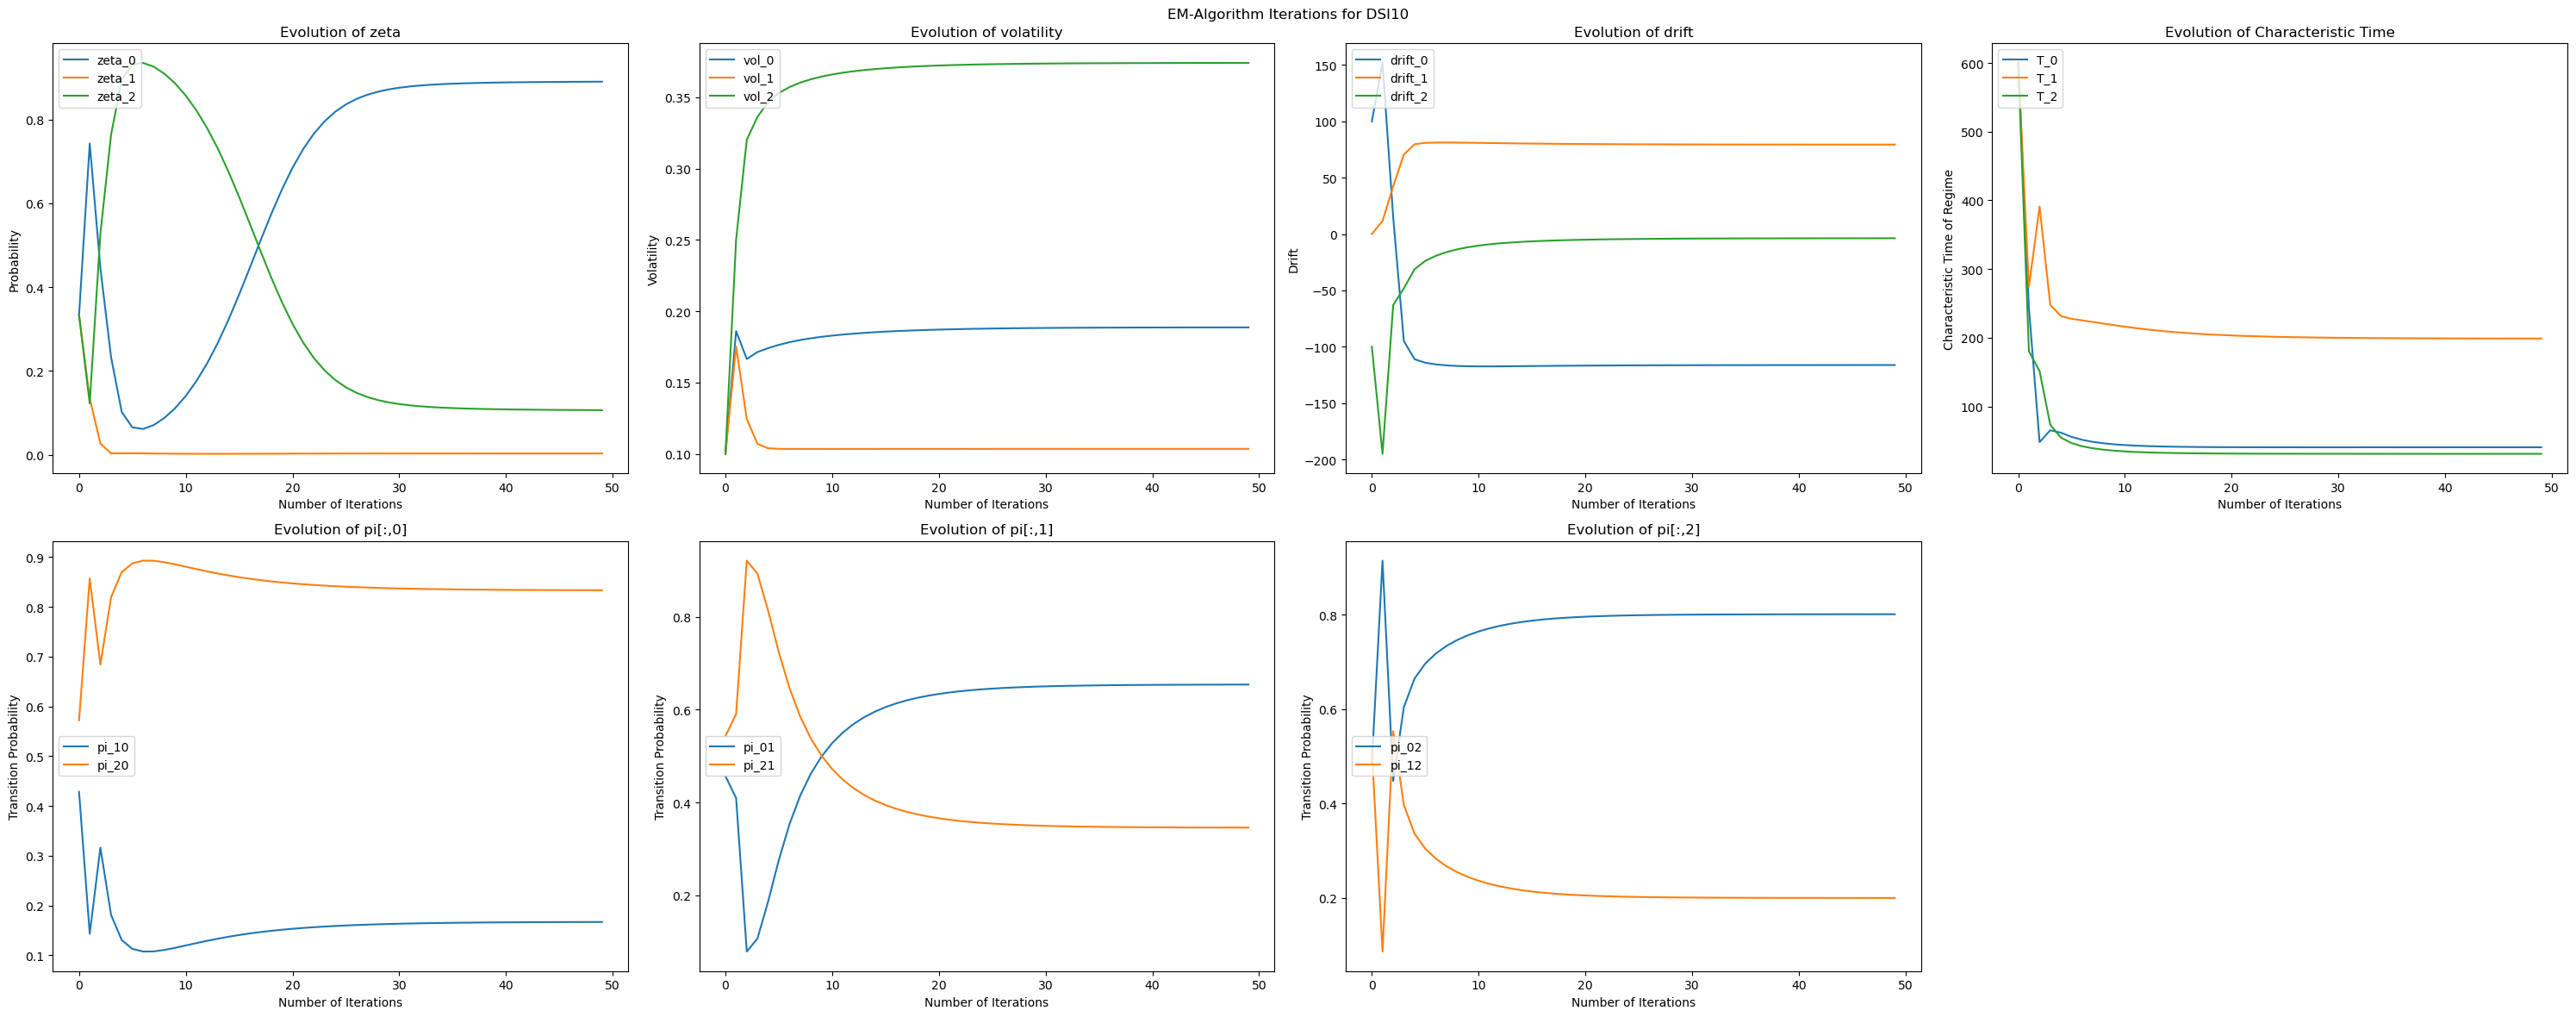

In [31]:
from EM_algo import EM_algo_general, see_convergence, init_P0

DSI_choice = 'DSI10'

specs = SPECS[DSI_choice]
feed = DSIs_demo_full_dict[DSI_choice]
feed_to_use = feed.bid
log_returns = np.log(feed_to_use/feed_to_use.shift(1))

T0 = np.ones(3)* specs['T']
P0 = init_P0(T0)
mu0 = np.array([1,0,-1])*dt * specs['mu']
sigma0 = np.array([1,1,1])*np.sqrt(dt) * specs['sigma']
zeta0 = np.ones(3) / 3
NIt = 50
P_EM, mu_EM, sigma_EM, zeta_EM, alpha_EM, beta_EM, chi_EM, phi_EM = EM_algo_general(log_returns[0:86400 * 14].dropna().to_numpy(),NIt,P0,mu0,sigma0,zeta0)

see_convergence(P_EM, mu_EM, sigma_EM, zeta_EM, DSI_choice)

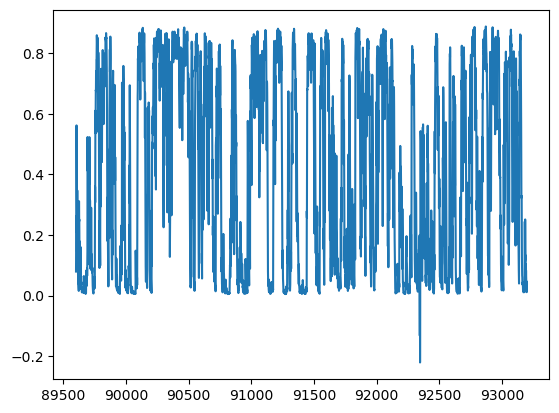

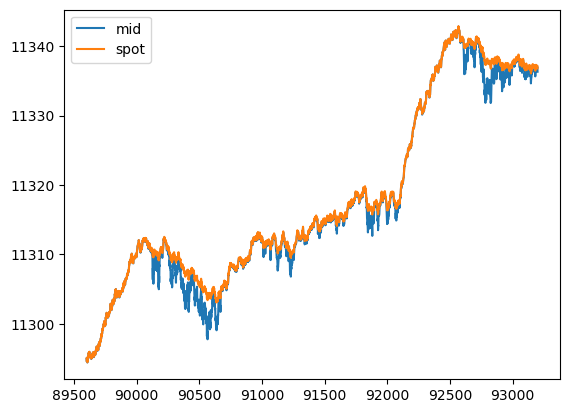

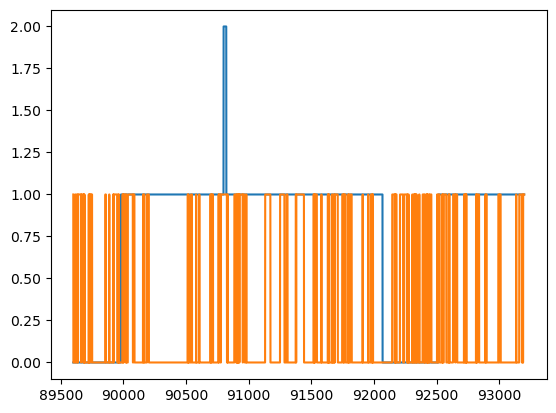

In [43]:
import numba as nb
from sklearn.linear_model import LinearRegression


@nb.njit(fastmath=True)
def norm_pdf(x : np.ndarray, mu, sigma):
    """
    Normal probability density function - WS Optimized

    Arguments
    ---------
    x : numpy.ndarray
        The log-return samples
    mu : np.ndarray
        The drifts for each regime
    sigma : float
        Constant volatility

    Returns
    -------
    numpy.ndarray
        Probability mass per log return per drift
    """
    result_pdf = np.empty((x.size, mu.size))
    for i in nb.prange(x.size):
        for j in nb.prange(mu.size):
            result_pdf[i, j] = 1 / (sigma[j] * np.sqrt(2*np.pi)) * np.exp(-((x[i] - mu[j]) / sigma[j])**2)
    return result_pdf

def _generate_diff_general(mus, sigmas, dt, state, log_returns, xi_0 = np.array([0,1,0], dtype=np.float64)):
    """
    Generates diff values for spread pricing - WS optimized

    Arguments
    ---------
    mus : float
        Array of 3 means
    sigmas : float
        Array of 3 constant volatilities
    dt : float
        Timestep
    state : numpy.ndarray
        3x3 Numpy array representing the Markov transition matrix
    log_returns : numpy.ndarray
        Array of log returns
    xi_0 : numpy.ndarray, Default [0,1,0]
        Starting distribution

    Returns
    -------
    tuple(numpy.ndarray, numpy.ndarray, numpy.ndarray)
        Numpy arrays contatining
        * Inference probabilities
        * Forecasting probabilities
        * diff values
    """
    num_steps = log_returns.shape[0]
    xi_forecast = np.zeros((num_steps+1, 3), dtype=np.float64)
    xi_forecast[0] = xi_0
    xi_inference = np.zeros((num_steps, 3), dtype=np.float64)
    mumu = (( mus - sigmas ** 2 / 2) * dt)
    conditional_dists = norm_pdf(log_returns, mu=mumu, sigma = sigmas * np.sqrt(dt))
    for i in range(num_steps):
        deno = np.dot(xi_forecast[i,:], conditional_dists[i,:])
        for j in range(3):
            xi_inference[i,j] = (xi_forecast[i, j] * conditional_dists[i, j]) / deno
        xi_forecast[i+1] = state @ xi_inference[i]
    diff = xi_forecast[:, 0] - xi_forecast[:,2]
    return xi_inference, xi_forecast, diff

def lin_reg_strat(bid, ask, diff, entry = 0.7, exit = -0.1):
    pass

DSI_choice = 'DSI10'

# params = MLE_results[DSI_choice]
sigma = sigma_EM[:,-1] / np.sqrt(dt)
mu = mu_EM[:,-1] / dt + sigma ** 2 / 2
P = P_EM[:,:,-1]
zeta = zeta_EM[:,-1]

DSI = DSIs_demo_phase_1_dict[DSI_choice]
log_returns = np.log(DSI.spot /DSI.spot.shift(1)).dropna().to_numpy()
xi_inference, xi_forecast, diff = _generate_diff_general(mu, sigma, dt, P, log_returns, zeta)
new_diff = xi_forecast[:, 0] - xi_forecast[:,2]
start = 89600
end = start + 3600
trunc = xi_forecast[start:end,:]
plt.plot(range(start, end), new_diff[start:end])
plt.figure()
plt.plot(DSI.bid[start:end])
plt.plot(DSI.spot[start:end])
plt.legend(['mid', 'spot'])
plt.figure()
plt.plot(DSI.state[start:end])
plt.plot(range(start,end), trunc[:,1] > 0.9)


### Section 6

As mentioned earlier, the spread formula is justified. In particular, if $F_t$ is a forward index for DSI $S_t$, then we can set:

$$
S_{ask} = \max(S_t, F_t)
$$

$$
S_{bid} = \min(S_t, F_t)
$$

Here, these bid/ask prices are:

* Consistent (Any strategy and feed history results in negative expected client pnl)
* Fair (Based on previous bid-ask information, we can find a strategy such that its expected pnl is 0)

on the perfect strategy.

However, the calculations required for the above are rigid and do not leave much room for additional commissions/markups. 

That being the case, the current spread model solves this issues, maintaining consistency, while while relaxing fairness enough so we can 
get a positive expected revenue.

For more details & a more formal justification, refer to the following documents:

1. [Forward Indices](https://docs.google.com/document/d/1Pq1kny8DH5139TezgT46NL1UFlAtEuIEhOF6yML_69I/edit) (Justification of use of forward prices for pricing CFDs)
2. [Pricing CFDs with Futures](https://docs.google.com/document/d/1CMKAEhKZnfWA1B0ns0-4T-RSi9j0rBOBh9d0P5szYwQ/edit) (Systematic method of finding consistent spread models assuming known forward pricing model)
3. [Forward Pricing for DSI](https://docs.google.com/document/d/1Ndi2abC1t3l_hesg5oozRX8lIVm7tNWPb_GwQgP4fFo/edit) (Finding forward pricing for DSI)
4. [CFD Spread Model for DSI](https://docs.google.com/document/d/1izyJsZyNMi8ZB46ed_x5z7ivZQiPHGrBVeJ8Fjndr1U/edit) (Consolidation of (3) and justification for using diff)
5. [DSI - Expected Revenue](https://docs.google.com/document/d/1wkFRbqdoFgggAHD6BWkyZndfNrjoNVGqWNlBFa-qU4g/edit) (Justification for the expected revenue being solely dependent on the commission terms)

All documents have been validated.

NOTE: There is a recurrence relation in [Forward Pricing for DSI](https://docs.google.com/document/d/1Ndi2abC1t3l_hesg5oozRX8lIVm7tNWPb_GwQgP4fFo/edit) whose derivation was added later. For some elaboration on the derivation, refer to the appendix

#### Spread parameters

According to [CFD Spread Model for DSI](https://docs.google.com/document/d/1izyJsZyNMi8ZB46ed_x5z7ivZQiPHGrBVeJ8Fjndr1U/edit), the spread formula used is appropriate. The document proves that basing the bid and ask prices on the expected infinite spot, $X$, is a consistent pricing for CFDs on the DSI. Indeed, as seen below, $X$ checks out with the [DSI BO Tool spreadsheet](https://docs.google.com/spreadsheets/d/10GROML2A0XabtyjF0D7qPcX_XKmD0nv5_0VGts60lto/edit#gid=348200679). In particular, from the former document:

* $\epsilon_{ask, Ref} = \left|\frac{1}{2}(L^+ + L^-) - 1 \right|$
* $\epsilon_{bid, Ref} = \left|L^0 - 1\right|$
* $Spread1_{ask, Ref} = \left|L^+ - 1\right|$
* $Spread1_{bid, Ref} = \left|L^- - 1\right|$
* $\kappa_{ask, Ref} = Spread1_{ask, Ref} - \epsilon_{ask, Ref}$
* $\kappa_{bid, Ref} = Spread1_{bid, Ref} - \epsilon_{bid, Ref}$

Where $L = [L^+, L^0, L^-]$ is essentially the expected drift of the DSI (considering the contribution of all 3 regimes). Some more detail has been provided in the appendix. Do note that there are some details not entirely elaborated in the former document, which has also been placed in the appendix.

#### Spread parameter calculation

We compare the calculations using [CFD Spread Model for DSI](https://docs.google.com/document/d/1izyJsZyNMi8ZB46ed_x5z7ivZQiPHGrBVeJ8Fjndr1U/edit) with the preset parameters in [DSI BO Specs](https://docs.google.com/document/d/13lLR7P7x-nPd4F37sjsl8GGSPBM4vm_RtD0XRXBnZqE/edit).

##### Result

The calculated $\kappa$'s and $\epsilon$'s match the corresponding values from from [DSI BO Tool](https://docs.google.com/spreadsheets/d/10GROML2A0XabtyjF0D7qPcX_XKmD0nv5_0VGts60lto/edit#gid=1335519223)

In [49]:
def calculate_state(lambda_val : float, gamma : float):
    return np.array([
    [ 1 - lambda_val    , gamma * lambda_val    , lambda_val / 2],
    [lambda_val / 2     , 1 - lambda_val        , lambda_val / 2],
    [lambda_val / 2     , (1-gamma) * lambda_val, 1 - lambda_val]
    ])

ref_constants = {'DSI10' : {'eps_ask' : 0.000001608149, 'kappa_ask' : 0.001268393717, 'eps_bid' : 0.0000032122775, 'kappa_bid' : 0.0012635732896},
             'DSI20' : {'eps_ask' : 0.00000231621965, 'kappa_ask' : 0.00152207353844, 'eps_bid' : 0.00000462954401, 'kappa_bid' : 0.00151512777478},
             'DSI30' : {'eps_ask' : 0.000001773476251, 'kappa_ask' : 0.001331813546891, 'eps_bid' : 0.000003545474, 'kappa_bid' : 0.001326494599}}

calc_constants = {'DSI10' : {},
             'DSI20' : {},
             'DSI30' : {}}
             
for DSI_choice in OFFERED:
    specs = SPECS[DSI_choice]
    mu = specs['mu']
    lambda_val =1 / specs['T']
    gamma = prod_gammas_only[DSI_choice]

    P = calculate_state(lambda_val, gamma)

    # Expected drift
    Q = np.array([
        [np.exp(mu * dt), 0, 0],
        [0, 1, 0],
        [0, 0, np.exp(- mu * dt)],
    ], dtype=object)
    A = (P @ Q)

    # Note that raising the exponent too high results in overflow, keep within 5-6 orders of magnitude
    exponent = 20_001

    # The estimated Expected Infinite Spot
    X = np.linalg.matrix_power(A, exponent)
    L = X.sum(axis=0)

    calc_constants[DSI_choice]['eps_ask_calc'] = abs((L[0] + L[2]) / 2 - 1)
    calc_constants[DSI_choice]['eps_bid_calc'] = abs(L[1] - 1)
    calc_constants[DSI_choice]['spread1_ask_calc'] = abs(L[0] - 1)
    calc_constants[DSI_choice]['spread1_bid_calc'] = abs(L[2] - 1)
    calc_constants[DSI_choice]['kappa_ask_calc'] = calc_constants[DSI_choice]['spread1_ask_calc'] - calc_constants[DSI_choice]['eps_ask_calc']
    calc_constants[DSI_choice]['kappa_bid_calc'] = calc_constants[DSI_choice]['spread1_bid_calc'] - calc_constants[DSI_choice]['eps_bid_calc']

# Generate readable df
multi_index = pd.MultiIndex.from_product([['Bid Kappa', 'Ask Kappa', 'Bid Epsilon', 'Ask Epsilon'], ['Calculated', 'Reference']], names=['Parameters', 'Values'])
parameters = pd.DataFrame(index=OFFERED, columns=multi_index)

for DSI_choice in OFFERED:
    parameters.loc[DSI_choice, ('Bid Kappa', 'Calculated')] = calc_constants[DSI_choice]['kappa_bid_calc']
    parameters.loc[DSI_choice, ('Ask Kappa', 'Calculated')] = calc_constants[DSI_choice]['kappa_ask_calc']
    parameters.loc[DSI_choice, ('Bid Epsilon', 'Calculated')] = calc_constants[DSI_choice]['eps_bid_calc']
    parameters.loc[DSI_choice, ('Ask Epsilon', 'Calculated')] = calc_constants[DSI_choice]['eps_ask_calc']

    parameters.loc[DSI_choice, ('Bid Kappa', 'Reference')] = ref_constants[DSI_choice]['kappa_bid']
    parameters.loc[DSI_choice, ('Ask Kappa', 'Reference')] = ref_constants[DSI_choice]['kappa_ask']
    parameters.loc[DSI_choice, ('Bid Epsilon', 'Reference')] = ref_constants[DSI_choice]['eps_bid']
    parameters.loc[DSI_choice, ('Ask Epsilon', 'Reference')] = ref_constants[DSI_choice]['eps_ask']

display(parameters)

cols = pd.Index(['Bid Kappa', 'Ask Kappa', 'Bid Epsilon', 'Ask Epsilon'], name='Error from Reference (%)')
errors = pd.DataFrame(index=OFFERED, columns=cols)
for first in parameters.columns.get_level_values(0).drop_duplicates():
    errors.loc[:,first] = abs(parameters[first]['Reference'] - parameters[first]['Calculated']) / parameters[first]['Reference'] * 100

display(errors)

Parameters   Bid Kappa               Ask Kappa             Bid Epsilon  \
Values      Calculated   Reference  Calculated   Reference  Calculated   
DSI10       0.00126357  0.00126357  0.00126839  0.00126839  0.00000321   
DSI20       0.00151513  0.00151513  0.00152207  0.00152207  0.00000463   
DSI30       0.00132649  0.00132649  0.00133181  0.00133181  0.00000355   

Parameters             Ask Epsilon              
Values       Reference  Calculated   Reference  
DSI10       0.00000321  0.00000161  0.00000161  
DSI20       0.00000463  0.00000232  0.00000232  
DSI30       0.00000355  0.00000177  0.00000177

Error from Reference (%),Bid Kappa,Ask Kappa,Bid Epsilon,Ask Epsilon
DSI10,0.00000001,0.00000004,0.00007197,0.00011067
DSI20,0.0,0.0,0.00000835,0.00002036
DSI30,0.00000011,0.00000007,0.00001352,0.00002925


#### Bid/Ask Spread Replication

Since the bid/ask spread is variable, we try to replicate the bid/ask spread with our own implementation of the DSI. We apply this to the the following data:

* Demo Phase 1
* Demo Phase 2

##### Results
The bid/ask prices match, minus rounding errors

In [21]:
from DSI import _spread
def test_bid_ask(DSI_choice, phase):
    if phase == 1:
        DSI_dict = DSIs_demo_phase_1_dict
        spread_version = DEMO_PHASE1
    elif phase == 2:
        DSI_dict = DSIs_demo_phase_2_dict
        spread_version = DEMO_PHASE2
    else:
        raise NotImplementedError('Only phase 1 or 2 allowed')
    DSI = DSI_dict[DSI_choice]
    DSI_specs = SPECS[DSI_choice]
    spread_specs = SPREAD_SPECS[spread_version][DSI_choice]
    
    ask_kappa = DSI_specs['ask_kappa']
    bid_kappa = DSI_specs['bid_kappa']
    ask_epsilon = DSI_specs['ask_epsilon']
    bid_epsilon = DSI_specs['bid_epsilon']
    pip = DSI_specs['pips']
    perf = spread_specs['perf']
    com_max = spread_specs['com_max']
    com_min = spread_specs['com_min']

    spot = DSI.spot
    diff = DSI.xi.map(lambda x : x[0] - x[2])
    
    fair_spread_ask, fair_spread_bid, com_ask, com_bid = _spread(perf, ask_kappa, ask_epsilon, bid_kappa, bid_epsilon, 
                                                                 pip, com_max, com_min, diff.to_numpy(dtype=np.float64))

    ask_price = spot * (1 + fair_spread_ask) + com_ask
    bid_price = spot * (1 - fair_spread_bid) - com_bid

    bid_differences = bid_price.round(2) - DSI.bid
    ask_differences = ask_price.round(2) - DSI.ask

    bid_difference_counts = bid_differences[abs(bid_differences) > 0.1]
    ask_difference_counts = ask_differences[abs(ask_differences) > 0.1]
    
    print(f'  Checking {DSI_choice}...')

    if bid_passed := not bid_difference_counts.shape[0]:
        print(f'  Bid Prices match')
    else:
        print(f'  Discrepancies found at indices {bid_difference_counts.index}')
    
    if ask_passed := not ask_difference_counts.shape[0]:
        print(f'  Ask Prices match')
    else:
        print(f'  Discrepancies found at indices {ask_difference_counts.index}')   

    return ask_passed and bid_passed

In [25]:
print('-'*25)
print('Test Demo Phase 1 Data:')
for DSI_choice in OFFERED:
    test_bid_ask(DSI_choice, 1)
    if DSI_choice != 'DSI30': print()
print('='*25+'\n')

-------------------------
Test Demo Phase 1 Data:
  Checking DSI10...
  Bid Prices match
  Ask Prices match

  Checking DSI20...
  Bid Prices match
  Ask Prices match

  Checking DSI30...
  Bid Prices match
  Ask Prices match



In [26]:
print('-'*25)
print('Test Demo Phase 2 Data:')
for DSI_choice in OFFERED:
    test_bid_ask(DSI_choice, 2)
    if DSI_choice != 'DSI30': print()
print('='*25+'\n')

-------------------------
Test Demo Phase 2 Data:
  Checking DSI10...
  Bid Prices match
  Ask Prices match

  Checking DSI20...
  Bid Prices match
  Ask Prices match

  Checking DSI30...
  Bid Prices match
  Ask Prices match



### Section 7

We check correlation of the DSIs to see if pair trading is possible. We expect a low correlation. If there is high correlation, there is possible concentration risk. We check for tick-wise and hourly log returns

We compare: 
* Feeddb Spots (Dev/Demo Full)
* Feeddb/MT5 Bid (Demo Phase 1/2)
* Feeddb/MT5 Ask (Demo Phase 1/2)

#### Results
* Feeddb (Dev): 
  * Spot log returns have low correlation
* Feeddb (Demo - Full/Phase 1 & 2):
  * Spot log returns have low correlation
  * Bid log returns have low correlation
  * Ask log returns have low correlation

In [8]:
def corr_feeds(DSI10, DSI20, DSI30, return_duration, column, suffix):
    feeds = DSI10[['ts',column]].merge(DSI20[['ts',column]], on='ts', suffixes=('_DSI10','_DSI20'))
    feeds = feeds.merge(DSI30[['ts',column]], on='ts')
    feeds.rename(columns={column : f'{column}_DSI30'}, inplace=True)

    log_returns = pd.DataFrame()
    for DSI_choice in OFFERED:
        log_returns[f'logr_{column}_{DSI_choice}_{suffix}'] = np.log(feeds[f'{column}_{DSI_choice}'] / feeds[f'{column}_{DSI_choice}'].shift(return_duration))

    log_returns.dropna(inplace=True)

    display(log_returns.corr())

# Dev Feeds
DSI10_dev = DSIs_dev_dict['DSI10']
DSI20_dev = DSIs_dev_dict['DSI20']
DSI30_dev = DSIs_dev_dict['DSI30']

# Demo Feeds
DSI10_demo_1 = DSIs_demo_phase_1_dict['DSI10']
DSI20_demo_1 = DSIs_demo_phase_1_dict['DSI20']
DSI30_demo_1 = DSIs_demo_phase_1_dict['DSI30']

DSI10_demo_2 = DSIs_demo_phase_2_dict['DSI10']
DSI20_demo_2 = DSIs_demo_phase_2_dict['DSI20']
DSI30_demo_2 = DSIs_demo_phase_2_dict['DSI30']

DSI10_demo_full = DSIs_demo_full_dict['DSI10']
DSI20_demo_full = DSIs_demo_full_dict['DSI20']
DSI30_demo_full = DSIs_demo_full_dict['DSI30']

##### Tick-wise

In [9]:
corr_feeds(DSI10_dev, DSI20_dev, DSI30_dev, 1, 'spot', 'dev')
corr_feeds(DSI10_demo_full, DSI20_demo_full, DSI30_demo_full, 1, 'spot', 'demo_full')
corr_feeds(DSI10_demo_1, DSI20_demo_1, DSI30_demo_1, 1, 'bid', 'demo_1')
corr_feeds(DSI10_demo_1, DSI20_demo_1, DSI30_demo_1, 1, 'ask', 'demo_2')
corr_feeds(DSI10_demo_2, DSI20_demo_2, DSI30_demo_2, 1, 'bid', 'demo_2')
corr_feeds(DSI10_demo_2, DSI20_demo_2, DSI30_demo_2, 1, 'ask', 'demo_2')

,logr_spot_DSI10_dev,logr_spot_DSI20_dev,logr_spot_DSI30_dev
logr_spot_DSI10_dev,1.00000000,-0.00192955,0.00031228
logr_spot_DSI20_dev,-0.00192955,1.00000000,-0.00026062
logr_spot_DSI30_dev,0.00031228,-0.00026062,1.00000000


,logr_spot_DSI10_demo_full,logr_spot_DSI20_demo_full,logr_spot_DSI30_demo_full
logr_spot_DSI10_demo_full,1.00000000,-0.00070600,0.00015378
logr_spot_DSI20_demo_full,-0.00070600,1.00000000,-0.00117092
logr_spot_DSI30_demo_full,0.00015378,-0.00117092,1.00000000


,logr_bid_DSI10_demo_1,logr_bid_DSI20_demo_1,logr_bid_DSI30_demo_1
logr_bid_DSI10_demo_1,1.00000000,-0.00108201,0.00162959
logr_bid_DSI20_demo_1,-0.00108201,1.00000000,-0.00208722
logr_bid_DSI30_demo_1,0.00162959,-0.00208722,1.00000000


,logr_ask_DSI10_demo_2,logr_ask_DSI20_demo_2,logr_ask_DSI30_demo_2
logr_ask_DSI10_demo_2,1.00000000,0.00015183,-0.00037784
logr_ask_DSI20_demo_2,0.00015183,1.00000000,-0.00034401
logr_ask_DSI30_demo_2,-0.00037784,-0.00034401,1.00000000


,logr_bid_DSI10_demo_2,logr_bid_DSI20_demo_2,logr_bid_DSI30_demo_2
logr_bid_DSI10_demo_2,1.00000000,-0.00156085,-0.00153604
logr_bid_DSI20_demo_2,-0.00156085,1.00000000,-0.00062528
logr_bid_DSI30_demo_2,-0.00153604,-0.00062528,1.00000000


,logr_ask_DSI10_demo_2,logr_ask_DSI20_demo_2,logr_ask_DSI30_demo_2
logr_ask_DSI10_demo_2,1.00000000,-0.00059276,0.00003137
logr_ask_DSI20_demo_2,-0.00059276,1.00000000,-0.00021295
logr_ask_DSI30_demo_2,0.00003137,-0.00021295,1.00000000


##### Hourly

In [10]:
corr_feeds(DSI10_dev, DSI20_dev, DSI30_dev, 3600, 'spot', 'dev')
corr_feeds(DSI10_demo_full, DSI20_demo_full, DSI30_demo_full, 3600, 'spot', 'demo_full')
corr_feeds(DSI10_demo_1, DSI20_demo_1, DSI30_demo_1, 3600, 'bid', 'demo_1')
corr_feeds(DSI10_demo_1, DSI20_demo_1, DSI30_demo_1, 3600, 'ask', 'demo_2')
corr_feeds(DSI10_demo_2, DSI20_demo_2, DSI30_demo_2, 3600, 'bid', 'demo_2')
corr_feeds(DSI10_demo_2, DSI20_demo_2, DSI30_demo_2, 3600, 'ask', 'demo_2')

,logr_spot_DSI10_dev,logr_spot_DSI20_dev,logr_spot_DSI30_dev
logr_spot_DSI10_dev,1.00000000,-0.08035416,0.00391263
logr_spot_DSI20_dev,-0.08035416,1.00000000,0.03361912
logr_spot_DSI30_dev,0.00391263,0.03361912,1.00000000


,logr_spot_DSI10_demo_full,logr_spot_DSI20_demo_full,logr_spot_DSI30_demo_full
logr_spot_DSI10_demo_full,1.00000000,0.02765958,0.06689022
logr_spot_DSI20_demo_full,0.02765958,1.00000000,-0.02939312
logr_spot_DSI30_demo_full,0.06689022,-0.02939312,1.00000000


,logr_bid_DSI10_demo_1,logr_bid_DSI20_demo_1,logr_bid_DSI30_demo_1
logr_bid_DSI10_demo_1,1.00000000,0.08030117,0.04583827
logr_bid_DSI20_demo_1,0.08030117,1.00000000,-0.03686655
logr_bid_DSI30_demo_1,0.04583827,-0.03686655,1.00000000


,logr_ask_DSI10_demo_2,logr_ask_DSI20_demo_2,logr_ask_DSI30_demo_2
logr_ask_DSI10_demo_2,1.00000000,0.08155024,0.04482290
logr_ask_DSI20_demo_2,0.08155024,1.00000000,-0.03915401
logr_ask_DSI30_demo_2,0.04482290,-0.03915401,1.00000000


,logr_bid_DSI10_demo_2,logr_bid_DSI20_demo_2,logr_bid_DSI30_demo_2
logr_bid_DSI10_demo_2,1.00000000,-0.06823288,0.07062304
logr_bid_DSI20_demo_2,-0.06823288,1.00000000,0.04847695
logr_bid_DSI30_demo_2,0.07062304,0.04847695,1.00000000


,logr_ask_DSI10_demo_2,logr_ask_DSI20_demo_2,logr_ask_DSI30_demo_2
logr_ask_DSI10_demo_2,1.00000000,-0.07365944,0.07828129
logr_ask_DSI20_demo_2,-0.07365944,1.00000000,0.04377123
logr_ask_DSI30_demo_2,0.07828129,0.04377123,1.00000000


## Appendix


### Obtaining Spread Parameters

This section will detail the intuition behind finding the vector $L$ in section 6. For the entire proof, please refer to [Forward Pricing for DSI](https://docs.google.com/document/d/1Ndi2abC1t3l_hesg5oozRX8lIVm7tNWPb_GwQgP4fFo/edit) & [CFD Spread Model for DSI](https://docs.google.com/document/d/1izyJsZyNMi8ZB46ed_x5z7ivZQiPHGrBVeJ8Fjndr1U/edit).

Recall that $P$ is the transition matrix. Let

$$
\mathbf{d} = \begin{pmatrix}
e^{\mu dt} \\ 0 \\ e^{-\mu dt}
\end{pmatrix}
$$

be the 1 tick drifts of each regime. If we define $Q$ to be the diagonal matrix generated by $\mathbf{d}$, i.e:

$$
Q = \begin{pmatrix}
e^{\mu dt} & 0 & 0 \\
0 & 0 & 0 \\
0 & 0 & e^{- \mu dt}
\end{pmatrix}
$$

and if $x$ is the vector of probabilities of the next regimes, then each coordinate of the vector $PQx$ essentially represents the expected drift vector after 1 step. E.g, 
* if $x= [1,0,0]$, then 
  
$$
\begin{align*}
PQx &= (P_{11}e^{\mu dt} + P_{12}e^{-\mu dt}, 0, 0)^T \\
&= \begin{pmatrix}\mathbb{E}\left(\frac{S_{1}}{S_{0}} \mid X_{1} = 0\right) \\ 0 \\ 0\end{pmatrix}
\end{align*}
$$

As $P$ is Markov, then we can apply $PQ$ to itself $n$ times to find that the drift vector after $n$ steps is $(PQ)^nx$. If so, we can then find the expected spot (The price of a forward outright on the DSI) after $n$ steps is :

$$
ES_n = \begin{pmatrix}
1 & 1 & 1
\end{pmatrix}
\cdot (PQ)^n x
$$

We can set $n \rightarrow \infty$ to find the expected infinite spot:

$$
ESI = \lim\limits_{n \rightarrow \infty} ES_n
$$

From which we get $L$, the expected infinite drift vector:

$$
L = \begin{pmatrix}L^+ & L^0 & L^-\end{pmatrix}^T = \lim\limits_{n \rightarrow \infty} \begin{pmatrix}
1 & 1 & 1
\end{pmatrix}
\cdot (PQ)^n
$$

### Deriving the limiting/stationary distribution $\pi$

The limiting/stationary distribution is required to calculate the moments of the DSI index. This section will detail the definition and calculations of the stationary distribution.

The limiting distribution is defined as the limit:

$$
\pi = \lim\limits_{n \rightarrow \infty} P^nx
$$

For a distribution vector $x$. As the transition matrix $P$ is positive recurrent, the limiting distribution is also the stationary distribution. Since this is the case, we can calculate it as follows: 

We solve the set of simultaneous equations presented by:

$$
\begin{gather*}
P \pi = \pi \\ \iff
\begin{pmatrix}
1 - \lambda & \gamma \lambda & \frac{\lambda}{2} \\
\frac{\lambda}{2} & 1 - \lambda & \frac{\lambda}{2} \\
\frac{\lambda}{2} & (1 - \gamma) \lambda & 1 - \lambda
\end{pmatrix}
\begin{pmatrix}
p_0 \\ p_1 \\ p_2
\end{pmatrix}
=
\begin{pmatrix}
p_0 \\ p_1 \\ p_2
\end{pmatrix}
\end{gather*}
$$

w.r.t $p_0, p_1, p_2$. Yielding:

$$
\pi = \begin{bmatrix}
\frac{2}{9}(1+\gamma) \\
\frac{1}{3} \\
\frac{2}{9}(2 - \gamma)
\end{bmatrix}
$$



### DSI log return MGF

We can calculate the moment-generating function for the log returns:

$$
R_t = \log \frac{S_t}{S_{t-1}} = \left(\mu(X_t) - \frac{\sigma^2}{2} \right) dt+ \sigma \sqrt{dt} W
$$

Indeed, using the independence of $X_t$ and $W$:

\begin{align*}
\mathbb{E}[e^{sR_t}] &= \mathbb{E}\left[e^{s\left(\mu(X_t) - \frac{\sigma^2}{2} \right) dt+ \sigma \sqrt{dt} W} \right] \\
&= \mathbb{E}\left[e^{s (\mu(X_t) dt)} \right] \cdot \mathbb{E}\left[e^{s\left(- \frac{\sigma^2}{2} dt\right)} \right] \cdot \mathbb{E}\left[e^{s(\sigma \sqrt{dt} W)} \right]
\end{align*}

We use the stationary distribution for the first term:

$$
\mathbb{E}\left[e^{s (\mu(X_t) dt)} \right] = \frac{2}{9}(1+\gamma)e^{\mu dt \cdot s} + \frac{1}{3} + \frac{2}{9}(2-\gamma)e^{-\mu dt \cdot s}
$$

The second term is an expectation of a constant, and the we can evaluate the third term as usual:

$$
\mathbb{E}\left[e^{s(\sigma \sqrt{dt} W)} \right] = e^{\frac{\sigma^2}{2}dt \cdot s}
$$

Putting everything together:

$$
MGF_{R_t}(s) = \mathbb{E}[e^{sR_t}] = e^{\frac{\sigma^2}{2} dt(s^2 - s)} \left(\frac{2}{9}(1+\gamma)e^{\mu dt \cdot s} + \frac{2}{9}(2-\gamma)e^{-\mu dt \cdot s} + \frac{1}{3} \right)
$$

Setting $D = \mu(X_t)dt$ and $N = \sigma \sqrt{dt} W - \frac{\sigma^2}{2} dt$, we can rewrite the moment generating function:

$$
MGF_{N+D}(s) = MGF_N(s) \cdot MGF_D(s)
$$

Where:

\begin{align*}
MGF_N(s) &= e^{\frac{\sigma^2}{2} dt(s^2 - s)} \\
MGF_D(s) &= \frac{2}{9}(1+\gamma)e^{\mu dt \cdot s} + \frac{2}{9}(2-\gamma)e^{-\mu dt \cdot s} + \frac{1}{3}
\end{align*}

### DSI log return moments:

We use the MGF to find the moments of $R_t$ using:

$$
\mathbb{E}[(R_t)^n] = \left. \frac{d^n}{ds^n} MGF_{N+D}(s) \right|_{s=0}
$$ 

Calculating the first three moments:

$$
\mathbb{E}[R_t] =  \left(\frac{2}{9}\mu (2 \gamma - 1) - \frac{\sigma^2}{2}\right) dt
$$

$$
\mathbb{E}[R_t^2] =  \left(\frac{2}{3}\mu^2 - \frac{2}{9} \mu\sigma^2 (2 \gamma - 1) + \frac{\sigma^4}{4} \right)dt^2 + \sigma^2 dt
$$

\begin{align*}
\mathbb{E}[R_t^3] = \left(\frac{2}{9}\mu^3(2 \gamma - 1) - \frac{\sigma^2}{3}\mu^2 + \frac{2}{9}\mu\sigma^4(2\gamma-1) - \frac{\sigma^6}{8} \right) dt^3  + \left(\frac{2}{9}\mu\sigma^2(2 \gamma - 1) - \frac{3}{2}\sigma^4\right) dt^2
\end{align*}

We can write this in terms of moments of $\mu(X_t)$. Note that the moments for $\mu(X_t)$ are:

$$
\mathbb{E}[\mu(X_t)^n] = \begin{cases} \frac{2}{9}\mu^n(2\gamma - 1) & \text{for $n$ odd} \\
\frac{2}{3}\mu^n & \text{for $n$ even}\end{cases}
$$

Therefore, we rewrite the moments of $R_t$:

$$
\mathbb{E}[R_t] =  \left(\mathbb{E}[\mu(X_t)] - \frac{\sigma^2}{2}\right) dt
$$

$$
\mathbb{E}[R_t^2] =  \left(\mathbb{E}[\mu(X_t)^2] - \sigma^2\mathbb{E}[\mu(X_t)]+ \frac{\sigma^4}{4} \right)dt^2 + \sigma^2 dt
$$

\begin{align*}
\mathbb{E}[R_t^3] = \left(\mathbb{E}[\mu(X_t)^3] - \frac{\sigma^2}{2}\mathbb{E}[\mu(X_t)^2] + \sigma^4\mathbb{E}[\mu(X_t)] - \frac{\sigma^6}{8} \right) dt^3  + \left( \sigma^2\mathbb{E}[\mu(X_t)] - \frac{3}{2}\sigma^4\right) dt^2
\end{align*}

### Forward Pricing Recursive Equations

Previously, in Forward Pricing for DSI, there was no derivation for the recursive relations. It has been already updated to include one. The following below is the same derivation but more detailed for my own understanding.

We define:

* $R \in \{+,0,-\}$ are the possible regimes;
  
* $S_t \xrightarrow[]{R} S_{t+1}$ is the event that $X_t = R$, i.e the step to $S_{t+1}$ follows regime $R$ ($X_t = R$);
  
* $F_1 = \begin{pmatrix} F_1^+ & F_1^0 & F_1^- \end{pmatrix} $ is the vector of prices of a forward contract on DSI after $n$ iterations. Each component is the forward contract price if the current spot is 1, and if the regime taking $S_0 \rightarrow S_1$ is $+$, $0$ and $-$ respectively. In the document, it is labeled as the vector of the forward price after 1 iteration. Will also be denoted as $B$;
  
* $B = F_1 = \begin{pmatrix} e^{\mu dt} - 1& 0 & e^{-\mu dt} - 1\end{pmatrix}^T$ is the vector of prices of a forward contract on DSI if the current spot is 1 after 1 iteration (The 1 tick returns);
  
* $\mathbb{P}(R_1 \rightarrow R_2) = \mathbb{P}(X_1 = R_2 \mid X_0 = R_1) $ is the transition probability $P_{R_2\leftarrow R_1}$

We consider $F_{m+1}^+$, for $m \geq 1$. The $0,-$ cases follow similar proofs.

We can rewrite $F_{m+1}^+$ in terms of the expected future spot, given that we start at 1, and $S_0 \xrightarrow[]{+} S_1$:

$$
1 + F_{m+1}^+ = \mathbb{E}[S_{m+1} \mid S_0 = 1, S_0 \xrightarrow[]{+} S_1]
$$

We condition on each possible $S_1 = s$ and also against the transition from $S_1 \xrightarrow[]{R} S_2$ for each regime $R$:

$$
1 + F_{m+1}^+ = \int_{\mathbb{R}} \sum_{R \in \{+,0,-\}} \mathbb{E}[S_{m+1} \mid S_0 = 1, S_0 \xrightarrow[]{+} S_1, S_1 = s, S_1 \xrightarrow[]{R} S_2] \cdot \mathbb{P}(S_1 = s, S_1 \xrightarrow[]{R} S_2 \mid S_0 = 1, S_0 \xrightarrow[]{+} S_1) \, ds
$$

We decompose each of the two terms:

The conditional expectation can be simplified:

1. The events $\{S_0 = 1, S_0 \xrightarrow[]{+} S_1\}$ & $\{S_1 = s, S_1 \xrightarrow[]{R} S_2 \mid S_0\}$ are independent. Moreover, under the standard filtration for the DSI, we see that the former event is measurable w.r.t the latter event. Using this, we can reduce:

\begin{align*}
\mathbb{E}[S_{m+1} \mid S_0 = 1, S_0 \xrightarrow[]{+} S_1, S_1 = s, S_1 \xrightarrow[]{R} S_2] &=  \mathbb{E}[\mathbb{E}(S_{m+1} \mid S_0 = 1, S_0 \xrightarrow[]{+} S_1) \mid S_1 = s, S_1 \xrightarrow[]{R} S_2]\\
&= \mathbb{E}[S_{m+1} \mid S_1 = s, S_1 \xrightarrow[]{R} S_2]
\end{align*}

2. Since $S_t$ is a martingale & $f_t(R) = S_t \xrightarrow[]{R} S_{t+1}$ is Markov on $t$, we can move 1 step back:

$$
\mathbb{E}[S_{m+1} \mid S_1 = s, S_1 \xrightarrow[]{R} S_2] = \mathbb{E}[S_{m} \mid S_0 = s, S_0 \xrightarrow[]{R} S_1]
$$

3. $S_t$ scales with the initial spot, $S_0$, so:

$$
\mathbb{E}[S_{m} \mid S_0 = s, S_0 \xrightarrow[]{R} S_1] = s \cdot \mathbb{E}[S_{m} \mid S_0 = 1, S_0 \xrightarrow[]{R} S_1]
$$

Now for the probability term:

1. $\{S_1 = s\}$ and $\{S_1 \xrightarrow[]{R} S_2\}$ are independent:

\begin{align*}
\mathbb{P}(S_1 = s, S_1 \xrightarrow[]{R} S_2 \mid S_0 = 1, S_0 \xrightarrow[]{+} S_1) &= \mathbb{P}(S_1 = s\mid S_0 = 1, S_0 \xrightarrow[]{+} S_1) \\
&\quad\cdot \mathbb{P}(S_1 \xrightarrow[]{R} S_2 \mid S_0 = 1, S_0 \xrightarrow[]{+} S_1)
\end{align*}

2. $\{S_1 \xrightarrow[]{R} S_2\}$ is independent of $\{S_0 = 1\}$ and therefore the second probability is just a transition probability

\begin{align*}
\mathbb{P}(S_1 = s, S_1 \xrightarrow[]{R} S_2 \mid S_0 = 1, S_0 \xrightarrow[]{+} S_1) &= \mathbb{P}(S_1 = s\mid S_0 = 1, S_0 \xrightarrow[]{+} S_1) \\
&\quad\cdot \mathbb{P}(S_1 \xrightarrow[]{R} S_2 \mid S_0 \xrightarrow[]{+} S_1) \\
&= \mathbb{P}(S_1 = s\mid S_0 = 1, S_0 \xrightarrow[]{+} S_1) \\
&\quad\cdot \mathbb{P}(+ \rightarrow R) 
\end{align*}

Reducing equation (1) with the above:

\begin{align*}
1 + F_{m+1}^+ &= \int_{\mathbb{R}} \sum_{R \in \{+,0,-\}} s \cdot \mathbb{E}[S_{m} \mid S_0 = 1, S_0 \xrightarrow[]{R} S_1] \cdot \mathbb{P}(S_1 = s\mid S_0 = 1, S_0 \xrightarrow[]{+} S_1) \cdot \mathbb{P}(+ \rightarrow R) \, ds \\
&= \sum_{R \in \{+,0,-\}} \left( \mathbb{E}[S_{m} \mid S_0 = 1, S_0 \xrightarrow[]{R} S_1] \cdot \mathbb{P}(+ \rightarrow R) \cdot \int_{\mathbb{R}} s \cdot \mathbb{P}(S_1 = s\mid S_0 = 1, S_0 \xrightarrow[]{+} S_1) \, ds \right) \\
&= \sum_{R \in \{+,0,-\}} \left( \mathbb{E}[S_{m} \mid S_0 = 1, S_0 \xrightarrow[]{R} S_1] \cdot \mathbb{P}(+ \rightarrow R) \cdot \mathbb{E}[S_1 \mid S_0 = 1, S_0 \xrightarrow[]{+} S_1] \right) 
\end{align*}

Recalling the definition of $F_m^+$ and expanding:

\begin{align*}
1 + F_{m+1}^+ &= \sum_{R \in \{+,0,-\}} (1+ F_m^R) \cdot (1+F_1^+) \cdot \mathbb{P}(+ \rightarrow R) \\
&= 1 + F_1^+ + \sum_{R \in \{+,0,-\}} F_m^R \cdot (1+ F_1^+) \cdot \mathbb{P}(+ \rightarrow R) \\
F_{m+1}^+ &= F_1^+ + \sum_{R \in \{+,0,-\}} F_m^R \cdot (1+ F_1^+) \cdot \mathbb{P}(+ \rightarrow R)
\end{align*}

Repeating for $F_{m+1}^0,F_{m+1}^-$, we get the same recursive relations as specified in the document.



### $\gamma$ Derivation

$\gamma$ is derived in the R&D document. The derivation of the recursive expressions for $X_n^R$ are not presented however. To obtain them, we can run a similar process as above. We define the following:

* $T_n$ is the time of the $n$-th change in regime with $T_0 = 0$;
* $R_t$ is the regime at time $t$;
* $R_{T_n}$ is the regime after the $n$-th change.

Recalling from the R&D document that:

* $\gamma_{r_2, r_1}$ is the probability that the next regime is $r_2$, given it was $r_1$ before;
* $e_{R,1} $ is the expected move assuming a start at the regime $R$ until the next regime change, i.e $e_{+,1} = \mathbb{E}[S_{T_1} \mid S_0=1, R_{T_0} = +]$;
* $e_{R,n}$ is the expected move assuming a start at the regime $R$ until the $n$-th regime change, i.e $e_{+,n} = \mathbb{E}[S_{T_n} \mid S_0=1, R_{T_0} = +]$;
* $X_{R,n} = e_{R,n} - 1$;
* $x_{R} = e_{R,1} - 1$.

In particular, from previous computations in the R&D document:

* $x_0 = 0$;
* $x_+ = \frac{\lambda e^{\mu dt}}{1 - e^{\mu dt}(1-\lambda)} - 1$;
* $x_- = \frac{\lambda e^{-\mu dt}}{1 - e^{-\mu dt}(1-\lambda)} - 1$

NOTE: The $e_R$'s have a different definition than the R&D document (p23), yet are still equivalent as:
1. The $e_R$ in the doc is equivalent to the expected move assuming a regime change instead of just moving into the stationary regime (As any regime change from the positive/negative is just moving into the stationary regime in the 2-ways case)
2. Hence, the $e_R$ in terms of regime change in the 2-ways case is equivalent to the $e_R$ in the 3-ways case, as both indices have equal chances of exiting a regime for any given starting regime.

We consider the positive regime case and expand in a similar manner to the proof before:

$$
1 + X_{+,n+1} = \mathbb{E}[S_{T_{n+1}} \mid S_0 = 1, R_{T_0} = +]
$$

Which leads to

$$
1 + X_{+,n+1} = \int_{\mathbb{R}} \sum_{R \in \{+,0,-\}} \mathbb{E}[S_{T_{n+1}} \mid S_0 = 1, R_{T_0} = +, S_{T_1} = s, R_{T_1} = R] \cdot \mathbb{P}(S_{T_1} = s, R_{T_1} = R \mid S_0 = 1, R_{T_0} = +) \, ds
$$

Invoking measurability & independence:

$$
1 + X_{+,n+1} = \int_{\mathbb{R}} \sum_{R \in \{+,0,-\}} \mathbb{E}[S_{T_{n+1}} \mid S_{T_1} = s, R_{T_1} = R] \cdot \mathbb{P}(S_{T_1} = s \mid S_0 = 1, R_{T_0} = +) \cdot \mathbb{P}(R_{T_1} = R \mid R_{T_0} = +) \, ds
$$

Recognizing that $\mathbb{P}(R_{T_1} = R \mid R_{T_0} = +)$ is just $\gamma_{R,+}$ and applying scaling invariance & independent increments to $S_t$:

$$
1 + X_{+,n+1} = \int_{\mathbb{R}} \sum_{R \in \{+,0,-\}} s\cdot\mathbb{E}[S_{T_{n}} \mid S_0 = 1, R_{T_0} = R] \cdot \mathbb{P}(S_{T_1} = s \mid S_0 = 1, R_{T_0} = +) \cdot \gamma_{R,+} \, ds
$$

Bringing out $\mathbb{E}[S_{T_{n}} \mid S_0 = 1, R_{T_0} = R]$ of the integral and evaluating it:

$$
1 + X_{+,n+1} =  \sum_{R \in \{+,0,-\}} \mathbb{E}[S_{T_{n}} \mid S_0 = 1, R_{T_0} = R] \cdot \mathbb{E}(S_{T_1} = s \mid S_0 = 1, R_{T_0} = +) \cdot \gamma_{R,+}
$$

Rewriting in terms of $x_R$ & $X_{R_n}$ and expanding:

$$
1 + X_{+,n+1} =  \sum_{R \in \{+,0,-\}} (1+X_{R,n})(1+x_+) \cdot \gamma_{R,+} = 1 + x_+ +  \sum_{R \in \{+,0,-\}} (1+x_+) \cdot X_{R,n}\cdot \gamma_{R,+}
$$

We get our relation:

$$
X_{+,n+1} = x_+ +  \sum_{R \in \{+,0,-\}} (1+x_+) \cdot X_{R,n}\cdot \gamma_{R,+}
$$

R&D effort needs to be in line with Deriv’s vision and mission as formulated by our CEO. Therefore all R&D projects are carefully selected by our C-Level senior management represented by JY and Rakshit and resources for the projects are only allocated after review and shortlisting based on their vision and priorities. 

In line with the standards and criterias set out by the CEO, the Model Validation team has validated the product/indices as documented in this report.